# Microsoft Malware Detection (Big Data 2015)

In [1]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import cv2
import array
from IPython.display import Image
from shutil import unpack_archive

In [11]:
#separating byte files and asm files 

source = 'train'
destination = 'byteFiles'

# we will check if the folder 'byteFiles' exists if it not there we will create a folder with the same name
if not os.path.isdir(destination):
    os.makedirs(destination)

# if we have folder called 'train' (train folder contains both .asm files and .bytes files) we will rename it 'asmFiles'
# for every file that we have in our 'asmFiles' directory we check if it is ending with .bytes, if yes we will move it to
# 'byteFiles' folder

# so by the end of this snippet we will separate all the .byte files and .asm files
if os.path.isdir(source):
    os.rename(source,'asmFiles')
    source='asmFiles'
    data_files = os.listdir(source)
    for file in data_files:
        if (file.endswith(".bytes")):
            shutil.move(source+'/'+file,destination)

<IPython.core.display.Javascript object>


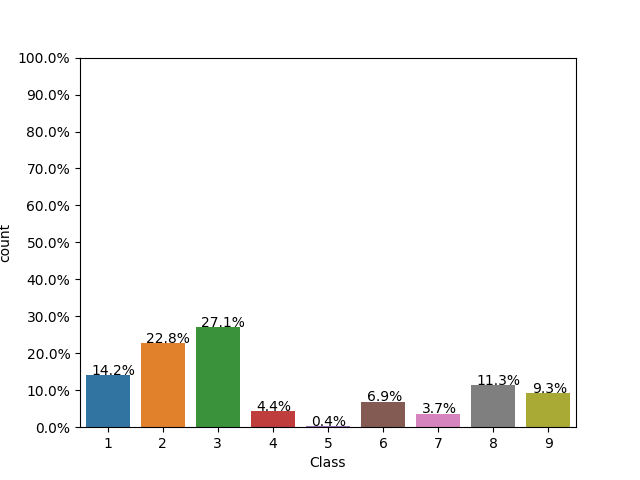

In [2]:
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
Y=pd.read_csv("trainLabels.csv")
total = len(Y)*1.
ax=sns.countplot(x="Class", data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [23]:
Y.head()

Id  Class
0  01kcPWA9K2BOxQeS5Rju      1
1  04EjIdbPV5e1XroFOpiN      1
2  05EeG39MTRrI6VY21DPd      1
3  05rJTUWYAKNegBk2wE8X      1
4  0AnoOZDNbPXIr2MRBSCJ      1

## Byte File Size

In [33]:
#file sizes of byte files

files=os.listdir('byteFiles')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('byteFiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
data_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (data_size_byte.head())

   Class                    ID      size
0      6  gyZztfseanvGp5uX2qix  0.468750
1      2  HSpxv7XiuwNj2ceELTnJ  6.140625
2      2  64FZCyUcjXxLNv1K8Bm3  3.506824
3      3  H7k4tXfrKFIZN1GqnYUw  6.703125
4      1  AjhW6ifgDC38ObQcJPa5  0.597656


In [25]:
data_size_byte['ID'] = data_size_byte["ID"]+".txt"

In [19]:
#removal of addres from byte files
# contents of .byte files
# ----------------
#00401000 56 8D 44 24 08 50 8B F1 E8 1C 1B 00 00 C7 06 08 
#-------------------
#we remove the starting address 00401000

files = os.listdir('byteFiles')
filenames=[]
array=[]
for file in files:
    if(file.endswith("bytes")):
        file=file.split('.')[0]
        text_file = open('byteFiles/'+file+".txt", 'w+')
        file = file+'.bytes'
        with open('byteFiles/'+file,"r") as fp:
            lines=""
            for line in fp:
                a=line.rstrip().split(" ")[1:]
                b=' '.join(a)
                b=b+"\n"
                text_file.write(b)
            fp.close()
            os.remove('byteFiles/'+file)
        text_file.close()

In [21]:
#program to convert into bag of words of bytefiles
#this is custom-built bag of words this is unigram bag of words
files = os.listdir('byteFiles')
filenames2=[]
feature_matrix = np.zeros((len(files),257),dtype=int)
k=0
byte_feature_file=open('result.csv','w+')
byte_feature_file.write("ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??")
for file in files:
    filenames2.append(file)
    byte_feature_file.write(file+",")
    if(file.endswith("txt")):
        with open('byteFiles/'+file,"r") as byte_flie:
            for lines in byte_flie:
                line=lines.rstrip().split(" ")
                for hex_code in line:
                    if hex_code=='??':
                        feature_matrix[k][256]+=1
                    else:
                        feature_matrix[k][int(hex_code,16)]+=1
        byte_flie.close()
    for i in feature_matrix[k]:
        byte_feature_file.write(str(i)+",")
    byte_feature_file.write("\n")
    
    k += 1

byte_feature_file.close()

In [47]:
byte_features=pd.read_csv("result.csv")
byte_features.head()

ID       0     1     2     3     4     5     6     7  \
0  01azqd4InC7m9JpocGv5.txt  601905  3905  2816  3832  3345  3242  3650  3201   
1  01IsoiSMh5gxyDYTl4CB.txt   39755  8337  7249  7186  8663  6844  8420  7589   
2  01jsnpXSAlgw6aPeDxrU.txt   93506  9542  2568  2438  8925  9330  9007  2342   
3  01kcPWA9K2BOxQeS5Rju.txt   21091  1213   726   817  1257   625   550   523   
4  01SuzwMJEIXsK7A8dQbl.txt   19764   710   302   433   559   410   262   249   

      8  ...    f7    f8    f9    fa    fb    fc    fd     fe     ff     ??  
0  2965  ...  2804  3687  3101  3211  3097  2758  3099   2759   5753   1824  
1  9291  ...   451  6536   439   281   302  7639   518  17001  54902   8588  
2  9107  ...  2325  2358  2242  2885  2863  2471  2786   2680  49144    468  
3  1078  ...   478   873   485   462   516  1133   471    761   7998  13940  
4   422  ...   847   947   350   209   239   653   221    242   2199   9008  

[5 rows x 258 columns]

## Merging Byte File and Byte file size

In [27]:
result = pd.merge(byte_features, data_size_byte,on='ID', how='left')
result.head()

ID       0     1     2     3     4     5     6     7  \
0  01azqd4InC7m9JpocGv5.txt  601905  3905  2816  3832  3345  3242  3650  3201   
1  01IsoiSMh5gxyDYTl4CB.txt   39755  8337  7249  7186  8663  6844  8420  7589   
2  01jsnpXSAlgw6aPeDxrU.txt   93506  9542  2568  2438  8925  9330  9007  2342   
3  01kcPWA9K2BOxQeS5Rju.txt   21091  1213   726   817  1257   625   550   523   
4  01SuzwMJEIXsK7A8dQbl.txt   19764   710   302   433   559   410   262   249   

      8  ...    f9    fa    fb    fc    fd     fe     ff     ??  Class  \
0  2965  ...  3101  3211  3097  2758  3099   2759   5753   1824      9   
1  9291  ...   439   281   302  7639   518  17001  54902   8588      2   
2  9107  ...  2242  2885  2863  2471  2786   2680  49144    468      9   
3  1078  ...   485   462   516  1133   471    761   7998  13940      1   
4   422  ...   350   209   239   653   221    242   2199   9008      8   

       size  
0  4.148438  
1  5.425781  
2  3.808594  
3  0.562500  
4  0.363281  

[5 rows x 260 columns]

In [28]:
# https://stackoverflow.com/a/29651514
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
result = normalize(result)

In [29]:
data_y = result['Class']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result.drop(['ID','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 8694
Number of data points in test data: 2174


In [36]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

## Random Model

Log loss on Cross Validation Data using Random Model 2.5238851364664967
Log loss on Test Data using Random Model 2.502799785991294
Number of misclassified points  89.0984360625575
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


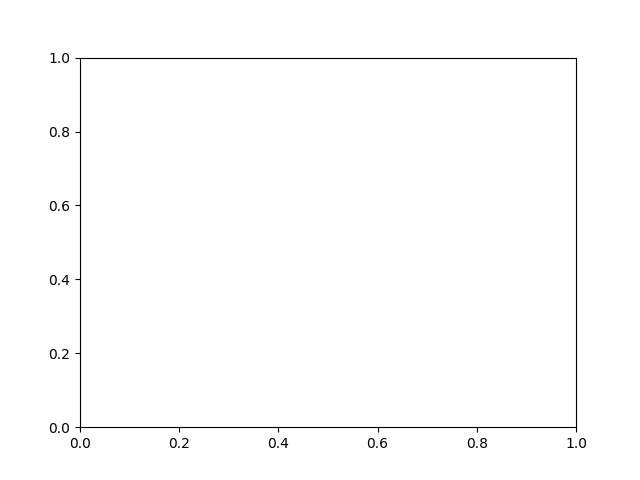

<IPython.core.display.Javascript object>


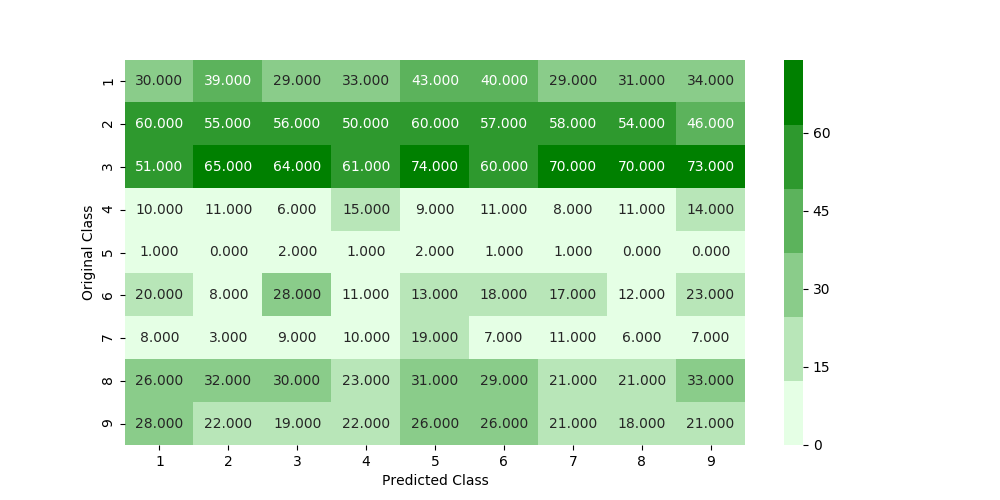

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


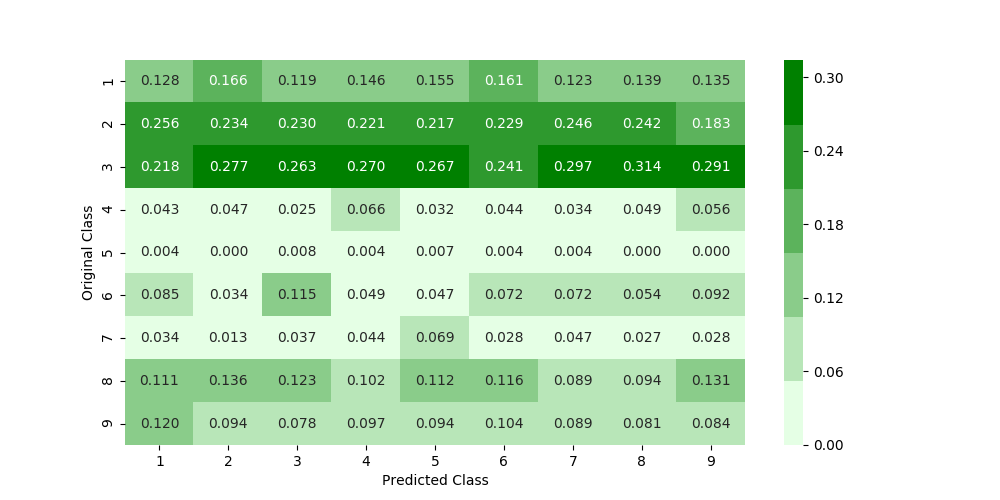

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


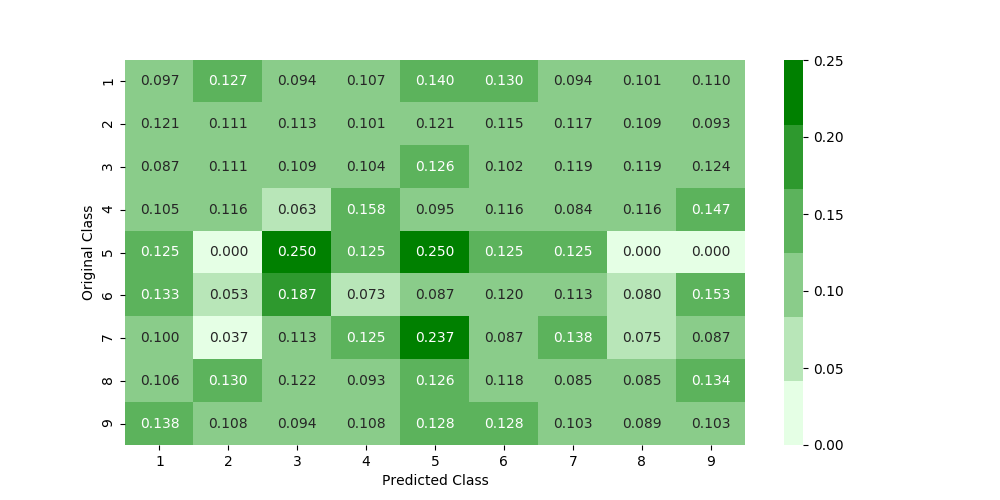

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [37]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039

test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

### From Random Model we get that our any model must contain log loss less than 2.502.
#### Acceptable range of log-loss of any model = [0, 2.502)

## K-Nearest Neighbors For Byte File Unigram

log_loss for k =  1 is 0.22689122613537194
log_loss for k =  3 is 0.22547571567503438
log_loss for k =  5 is 0.252808135009941
log_loss for k =  7 is 0.2750007325615408
log_loss for k =  9 is 0.2890894657959799
log_loss for k =  11 is 0.3034497925368818
log_loss for k =  13 is 0.31615524931236133


<IPython.core.display.Javascript object>


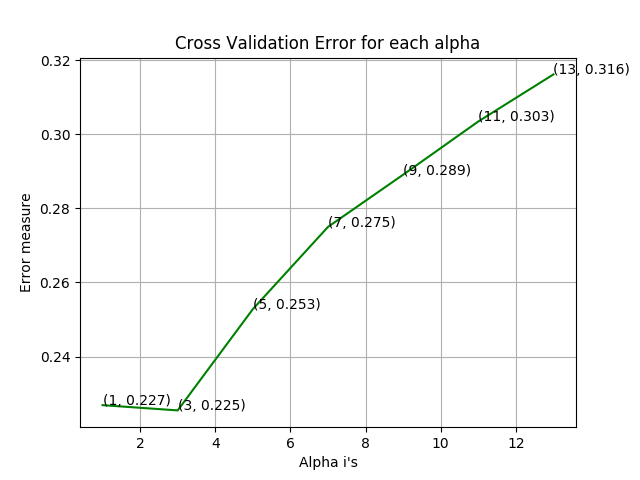

For values of best alpha =  3 The train log loss is: 0.12368759998407856
For values of best alpha =  3 The cross validation log loss is: 0.22547571567503438
For values of best alpha =  3 The test log loss is: 0.21545415878703672
Number of misclassified points  5.519779208831647
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


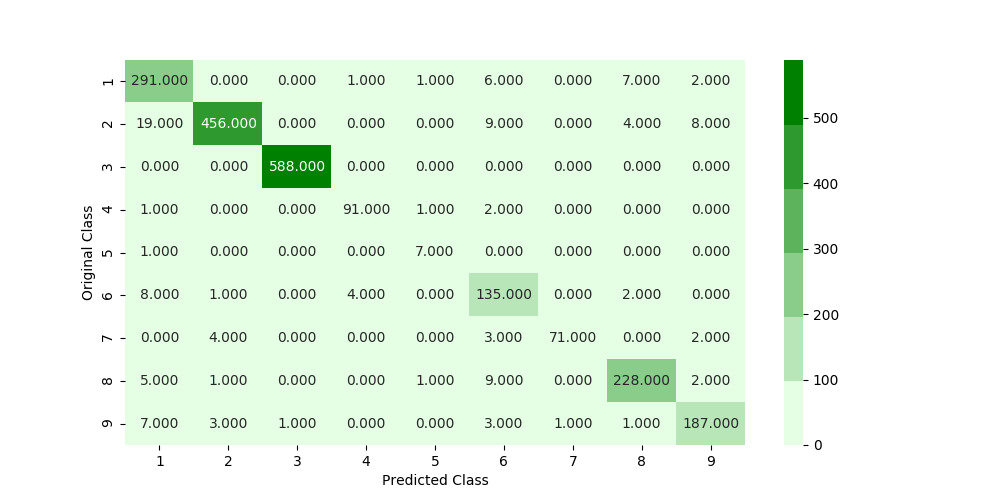

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


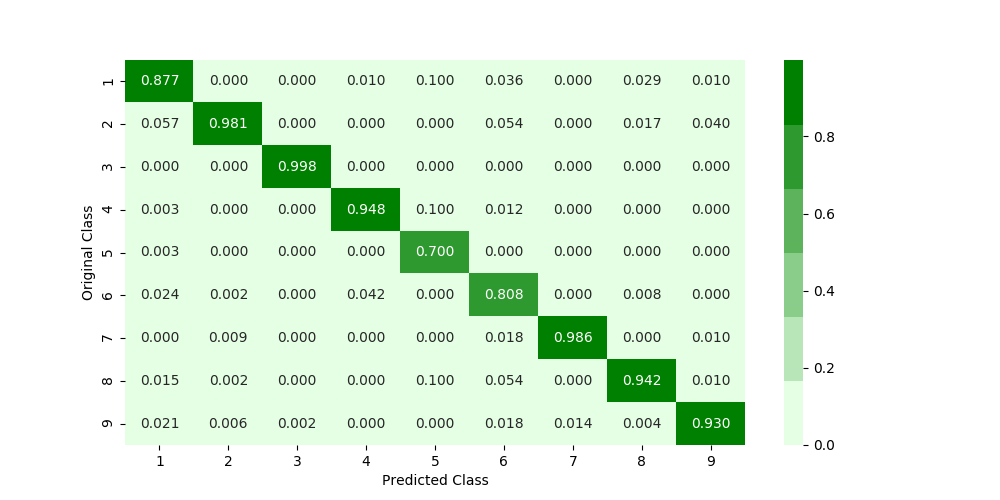

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


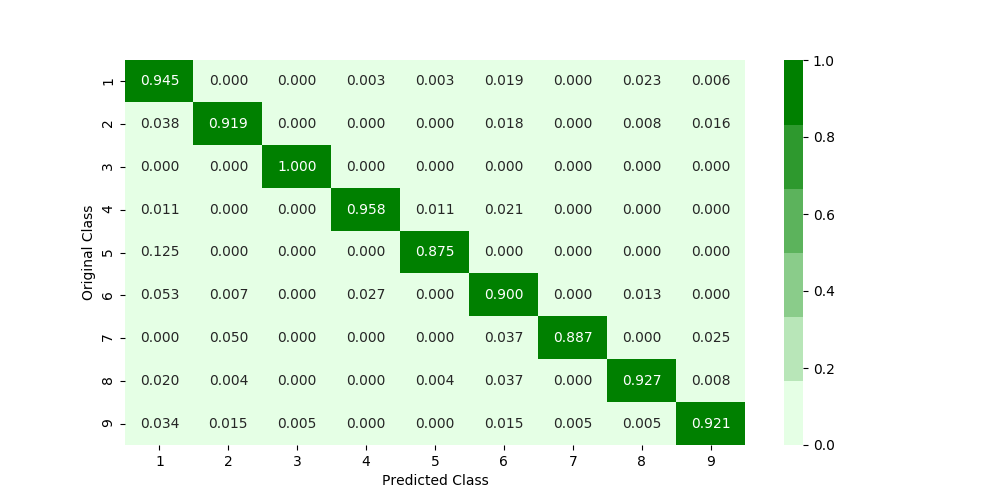

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [38]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
  
alpha = [x for x in range(1, 15, 2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## Logistic Regression For Byte File Unigram

log_loss for c =  1e-05 is 1.5768028303294428
log_loss for c =  0.0001 is 1.5808810485731137
log_loss for c =  0.001 is 1.548357093595411
log_loss for c =  0.01 is 1.049783080518207
log_loss for c =  0.1 is 0.8978297097252268
log_loss for c =  1 is 0.7642422289839638
log_loss for c =  10 is 0.6338076738379842
log_loss for c =  100 is 0.5796990321822336
log_loss for c =  1000 is 0.6536239926551165


<IPython.core.display.Javascript object>


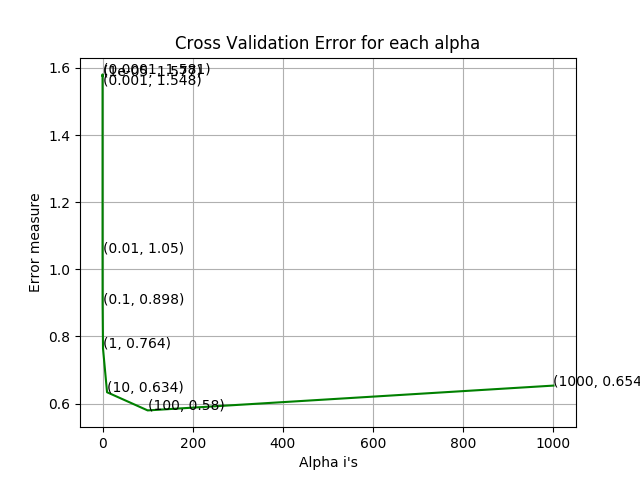

log loss for train data 0.4915610861886971
log loss for cv data 0.5796990321822336
log loss for test data 0.5576387448193763
Number of misclassified points  13.431462741490341
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


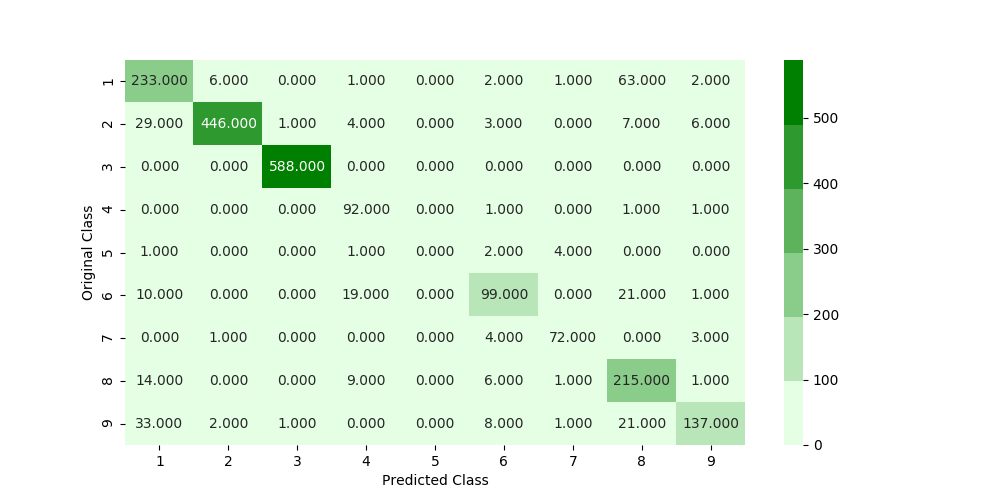

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


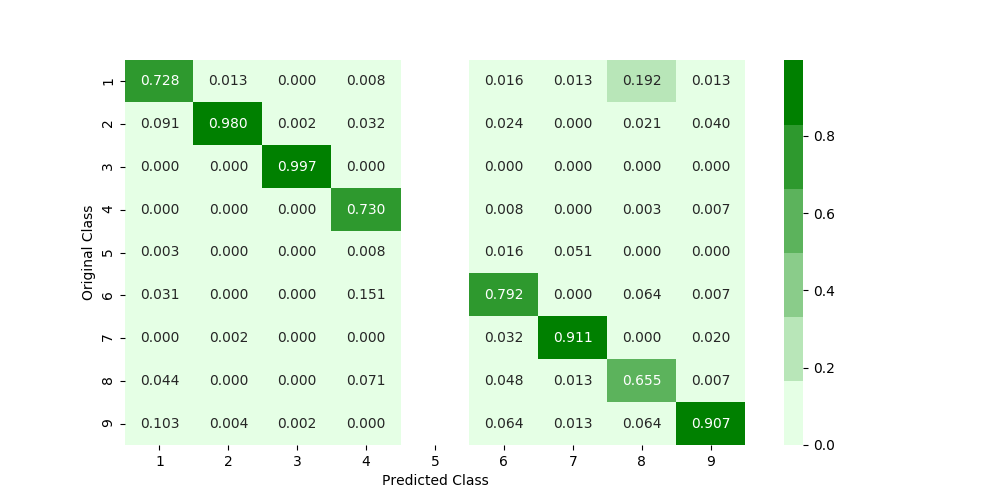

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


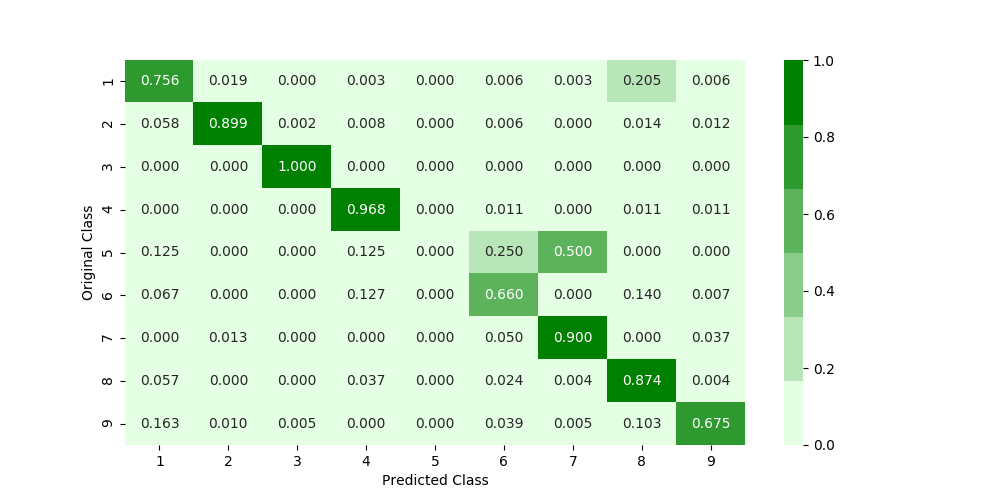

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [39]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------

alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
pred_y=sig_clf.predict(X_test)

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## Random Forest Classifier  For Byte File Unigram

log_loss for c =  10 is 0.10197801911014144
log_loss for c =  50 is 0.07749728561407908
log_loss for c =  100 is 0.07348029531304635
log_loss for c =  500 is 0.07231190509558852
log_loss for c =  1000 is 0.07134465195239031
log_loss for c =  2000 is 0.07167936145546173
log_loss for c =  3000 is 0.0717189344043146


<IPython.core.display.Javascript object>


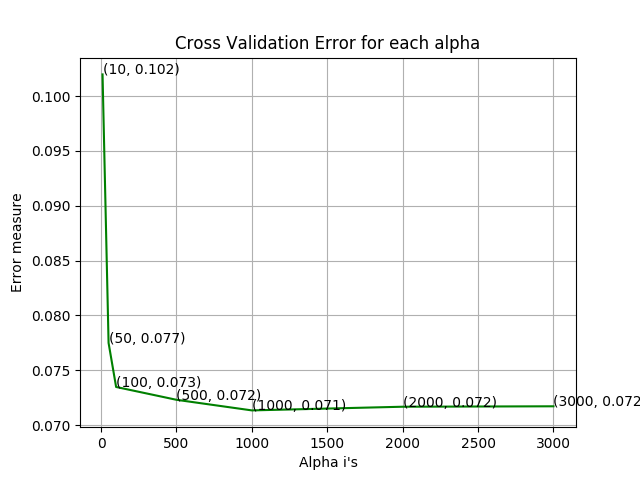

For values of best alpha =  1000 The train log loss is: 0.028227354589140143
For values of best alpha =  1000 The cross validation log loss is: 0.07134465195239031
For values of best alpha =  1000 The test log loss is: 0.08164354260441939
Number of misclassified points  1.7939282428702852
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


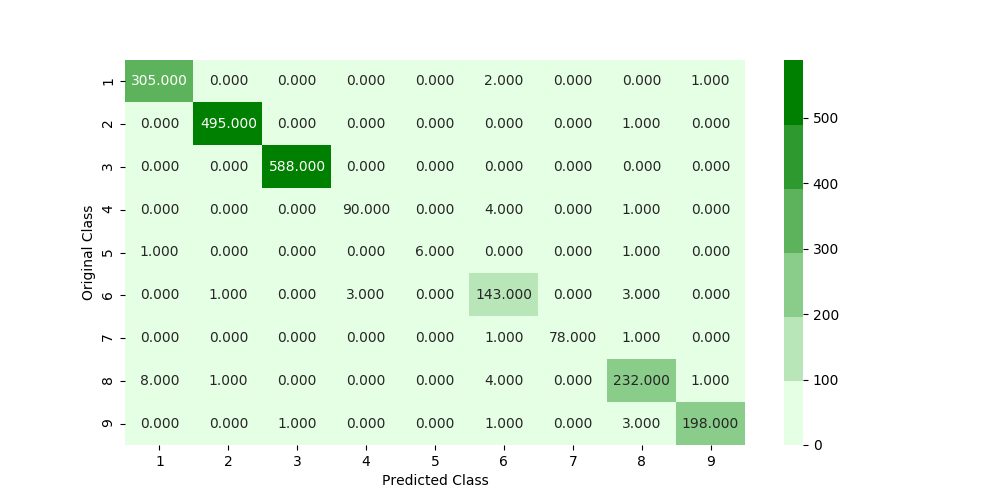

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


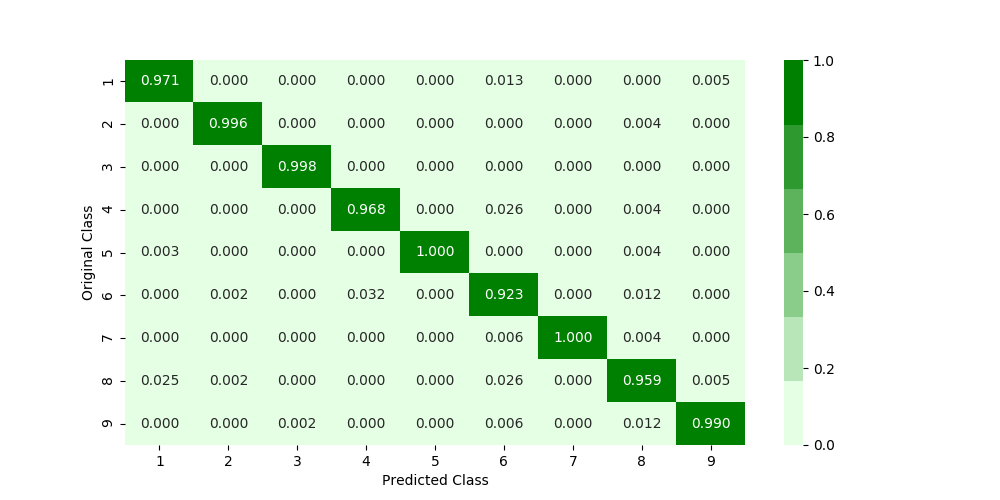

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


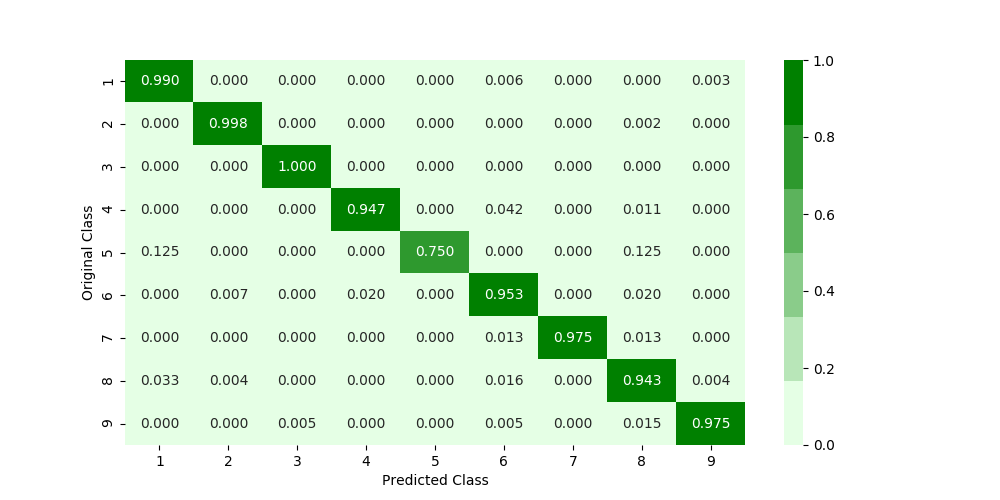

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [40]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## XG Boost Classifier  For Byte File Unigram

log_loss for c =  10 is 0.19036084511450996
log_loss for c =  50 is 0.10019540108806577
log_loss for c =  100 is 0.07089058549635496
log_loss for c =  500 is 0.058415297937366994
log_loss for c =  1000 is 0.05915894612549048
log_loss for c =  2000 is 0.05902946730763941


<IPython.core.display.Javascript object>


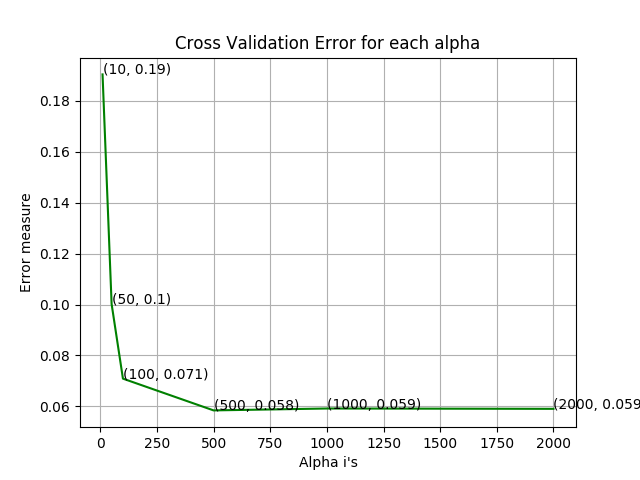

For values of best alpha =  500 The train log loss is: 0.02360881062700399
For values of best alpha =  500 The cross validation log loss is: 0.058415297937366994
For values of best alpha =  500 The test log loss is: 0.07746677766265561
Number of misclassified points  1.4719411223551058
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


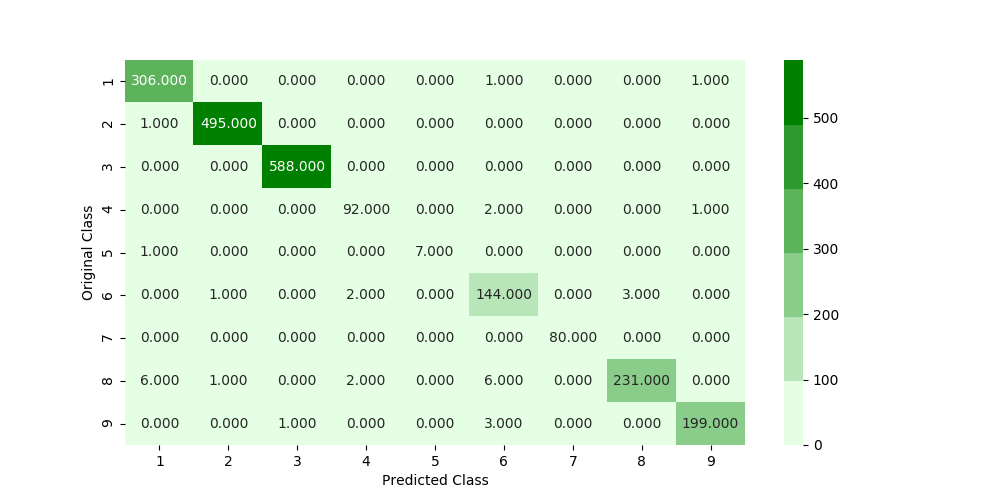

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


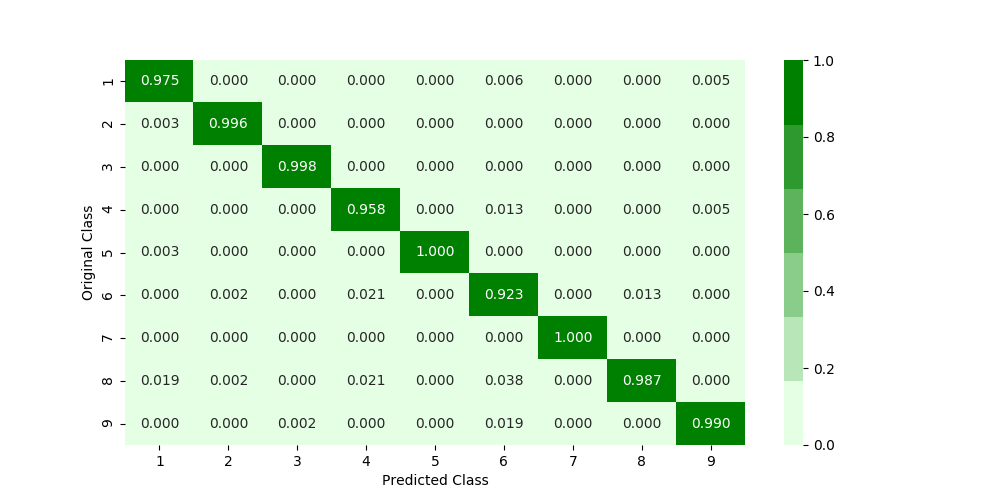

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


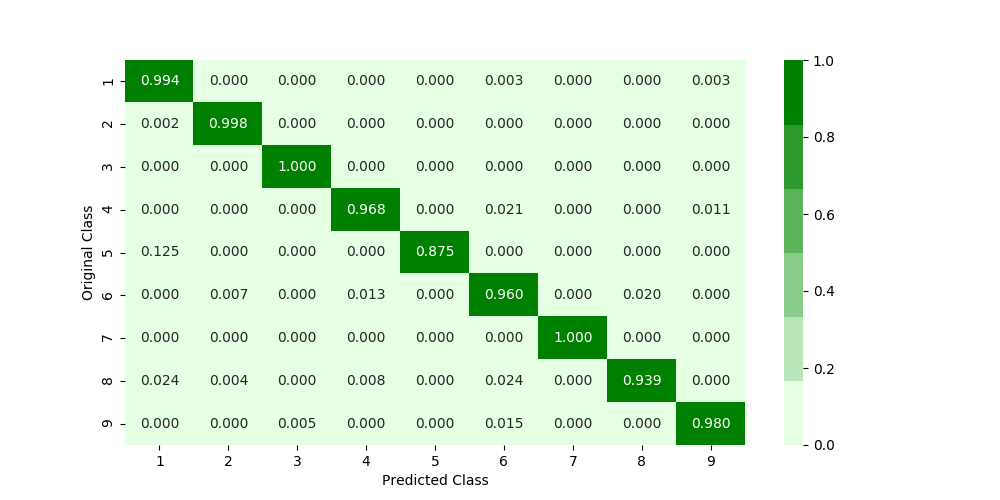

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [41]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## XG Boost + Hyperparameter Tuning  For Byte File Unigram

In [42]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train,y_train)
print("="*70)
print("Best Hyperparameters")
best = random_cfl1.best_params_
print (random_cfl1.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  6.3min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 11.2min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 12.0min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.1min finished


Best Hyperparameters
{'subsample': 0.3, 'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 10, 'colsample_bytree': 1}


train loss 0.020462678510523545
test loss 0.06732153987636007
Number of misclassified points  1.3799448022079117
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


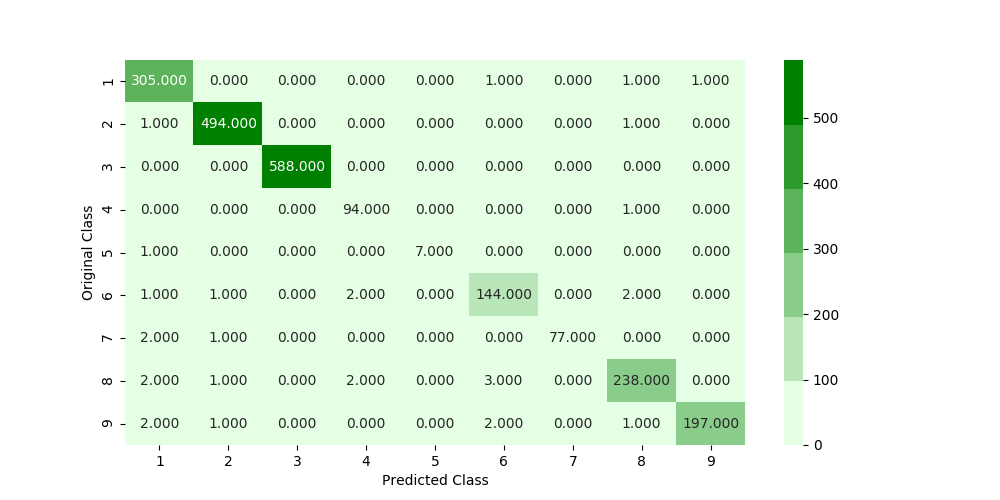

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


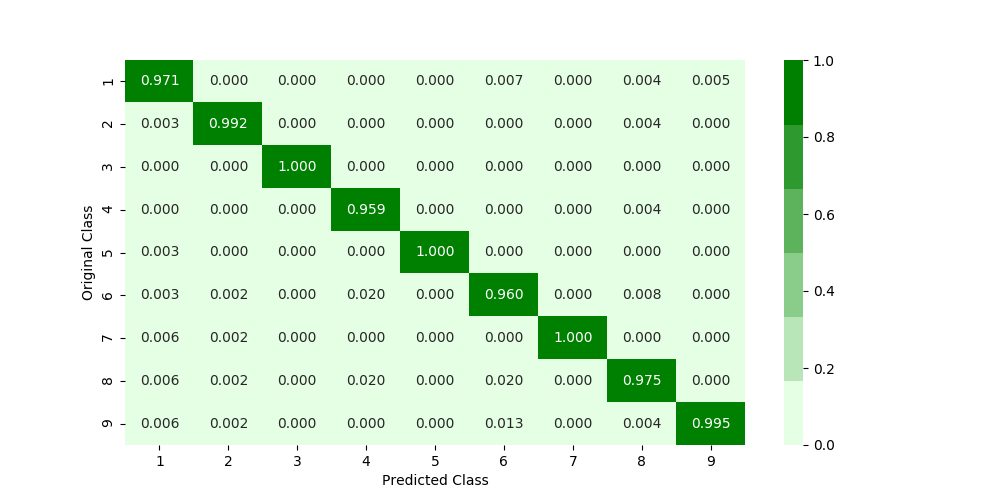

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


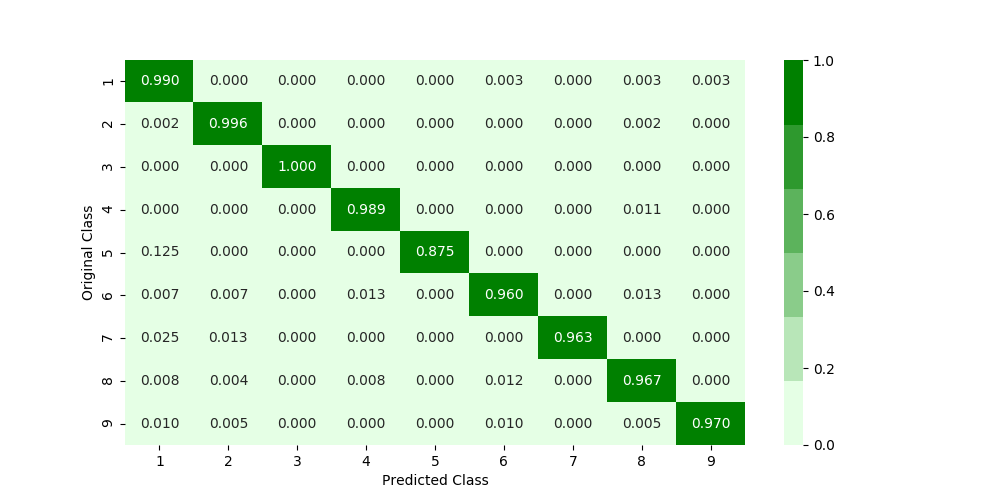

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [30]:
x_cfl=XGBClassifier(n_estimators=2000, learning_rate=0.05, colsample_bytree=1, max_depth=5, subsample=0.3)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
#predict_y = c_cfl.predict_proba(X_cv)
#print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, c_cfl.predict(X_test))

In [2]:
unigram = "00,01,02,03,04,05,06,07,08,09,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??"

def bi_gram(uni_gram):
    bigram = []
    for i, k in enumerate(uni_gram.split(',')):
        for j in range(len(uni_gram.split(','))):
            bigram.append(k + ' '+uni_gram.split(',')[j])
    return bigram

bigram = bi_gram(unigram)
print("Number of features in bigram = ",len(bigram))
print("First 10 elements")
print(bigram[:10])

Number of features in bigram =  66049
First 10 elements
['00 00', '00 01', '00 02', '00 03', '00 04', '00 05', '00 06', '00 07', '00 08', '00 09']


## Defining Byte file Bi-Gram

In [22]:
from scipy.sparse import csr_matrix
vec = CountVectorizer(lowercase=False, ngram_range=(2,2), vocabulary=bigram)
bigram_matrix = np.((10868, 66049))
files = os.listdir('byteFiles')
for i,file in enumerate(files):
    f = open('byteFiles/' + file)
    can = vec.fit_transform([f.read().replace('\n',' ').lower()])
    #can.reshape(1,-1)
    bigram_matrix[i,:]+=can
    f.close()

In [24]:
bigram_result = pd.DataFrame(bigram_matrix, columns = bigram)
bigram_result['ID'] = files
bigram_result.head()

00 00  00 01  00 02  00 03  00 04  00 05  00 06  00 07  00 08  00 09  \
0   9765.0   54.0    2.0    7.0   21.0    6.0    2.0   30.0    7.0    1.0   
1  22308.0  743.0   71.0   53.0  186.0   12.0    9.0   15.0   41.0   25.0   
2  34806.0  872.0  582.0  468.0  291.0  102.0  143.0  125.0  232.0  173.0   
3   4189.0   23.0   22.0   48.0   10.0   30.0   24.0   20.0   20.0   34.0   
4  23753.0  405.0  150.0  191.0  173.0   56.0   25.0   72.0   68.0  117.0   

   ...  ?? f8  ?? f9  ?? fa  ?? fb  ?? fc  ?? fd  ?? fe  ?? ff  ?? ??  \
0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                         ID  
0  gyZztfseanvGp5uX2qix.txt  
1  HSpxv7XiuwNj2ceELTnJ.txt  
2  64FZCyUcjXxLNv1K8Bm3.txt  
3  H7k4tXfrKFIZN1GqnYUw.txt  
4  AjhW6ifgDC38ObQcJPa5.txt  

[5 rows x 66050 columns]

In [25]:
Y=pd.read_csv("trainLabels.csv")
Y['ID'] = Y['Id']+'.txt'
Y = Y.drop(['Id'], axis=1)
byte_bigram = pd.merge(byte_bigram, Y, on ='ID', how='left')
data_y = byte_bigram['Class']
X = byte_bigram.drop(['ID','Class'], axis=1)

chi_feature=SelectKBest(chi2, k=2000)
byte_bigram_top=chi_feature.fit_transform(X, data_y)
print(byte_bigram_top.shape)

byte_bi = pd.DataFrame(byte_bigram_top)
byte_bi['ID'] = byte_bigram['ID']
byte_bi.to_csv('byte_bigram.csv')

(10868, 2000)


In [32]:
bigram_result = pd.read_csv('byte_bigram.csv')
result2 = normalize(bigram_result)

In [33]:
data_y = result['Class']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result2.drop(['ID','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739


log_loss for c =  10 is 0.10197801911014144
log_loss for c =  50 is 0.07749728561407908
log_loss for c =  100 is 0.07348029531304635
log_loss for c =  500 is 0.07231190509558852
log_loss for c =  1000 is 0.07134465195239031
log_loss for c =  2000 is 0.07167936145546173
log_loss for c =  3000 is 0.0717189344043146


<IPython.core.display.Javascript object>


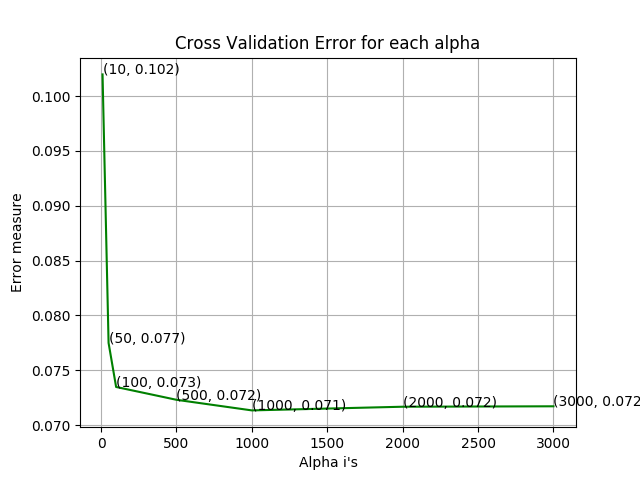

For values of best alpha =  1000 The train log loss is: 0.028227354589140143
For values of best alpha =  1000 The cross validation log loss is: 0.07134465195239031
For values of best alpha =  1000 The test log loss is: 0.08164354260441939
Number of misclassified points  1.7939282428702852
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


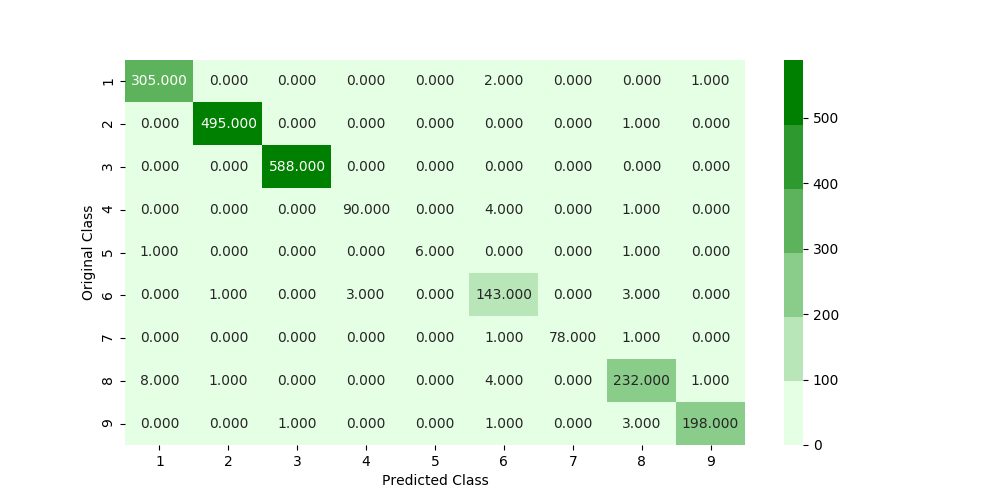

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


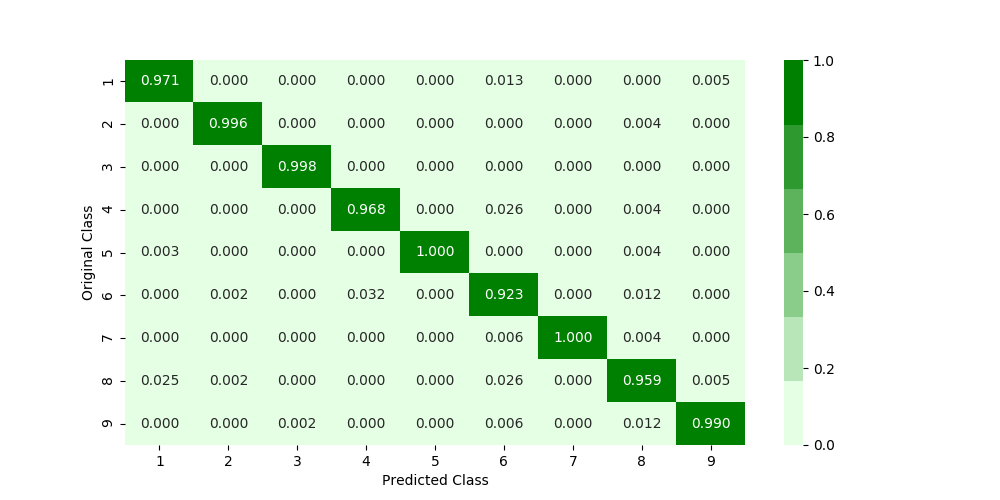

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


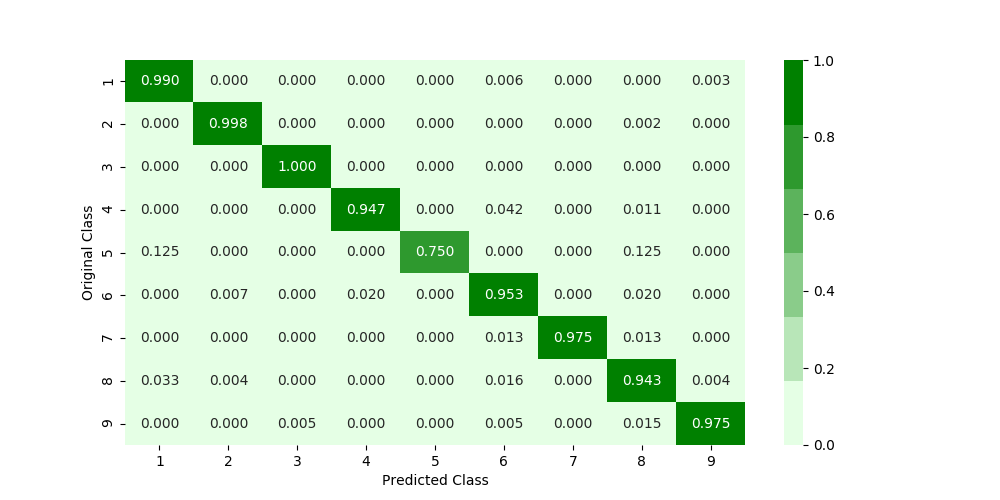

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [40]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## ASM features

In [35]:
# asmoutputfile.csv(output genarated from the above two cells) will contain all the extracted features from .asm files
# this file will be uploaded in the drive, you can directly use this
dfasm=pd.read_csv("asmoutputfile.csv")
#Y.columns = ['ID', 'Class']
#result_asm = pd.merge(dfasm, Y,on='ID', how='left')
dfasm.head()

ID  HEADER:  .text:  .Pav:  .idata:  .data:  .bss:  \
0  01kcPWA9K2BOxQeS5Rju       19     744      0      127      57      0   
1  1E93CpP60RHFNiT5Qfvn       17     838      0      103      49      0   
2  3ekVow2ajZHbTnBcsDfX       17     427      0       50      43      0   
3  3X2nY7iQaPBIWDrAZqJe       17     227      0       43      19      0   
4  46OZzdsSKDCFV8h7XWxf       17     402      0       59     170      0   

   .rdata:  .edata:  .rsrc:  ...  :dword  edx  esi  eax  ebx  ecx  edi  ebp  \
0      323        0       3  ...     137   18   66   15   43   83    0   17   
1        0        0       3  ...     130   18   29   48   82   12    0   14   
2      145        0       3  ...      84   13   42   10   67   14    0   11   
3        0        0       3  ...      25    6    8   14    7    2    0    8   
4        0        0       3  ...      18   12    9   18   29    5    0   11   

   esp  eip  
0   48   29  
1    0   20  
2    0    9  
3    0    6  
4    0   11  

[5 rows x 52 columns]

In [28]:
dfasm['ID']=dfasm['ID']+'.asm'

In [11]:
result_asm= result_asm.drop(['Id'], axis=1)
result_asm = normalize(result_asm)

In [13]:
for i in result_asm.columns:
    if result_asm[i].isnull().sum() != 0:
        result_asm.drop([i], axis=1, inplace=True)
result_asm.head()

ID   HEADER:    .text:  .Pav:   .idata:    .data:  .bss:  \
0  01kcPWA9K2BOxQeS5Rju  0.107345  0.001092    0.0  0.000761  0.000023    0.0   
1  1E93CpP60RHFNiT5Qfvn  0.096045  0.001230    0.0  0.000617  0.000019    0.0   
2  3ekVow2ajZHbTnBcsDfX  0.096045  0.000627    0.0  0.000300  0.000017    0.0   
3  3X2nY7iQaPBIWDrAZqJe  0.096045  0.000333    0.0  0.000258  0.000008    0.0   
4  46OZzdsSKDCFV8h7XWxf  0.096045  0.000590    0.0  0.000353  0.000068    0.0   

    .rdata:  .edata:    .rsrc:  ...       edx       esi       eax       ebx  \
0  0.000084      0.0  0.000072  ...  0.000343  0.000746  0.000301  0.000360   
1  0.000000      0.0  0.000072  ...  0.000343  0.000328  0.000965  0.000686   
2  0.000038      0.0  0.000072  ...  0.000248  0.000475  0.000201  0.000560   
3  0.000000      0.0  0.000072  ...  0.000114  0.000090  0.000281  0.000059   
4  0.000000      0.0  0.000072  ...  0.000229  0.000102  0.000362  0.000243   

        ecx  edi       ebp       esp       eip  Class  
0  0.001057  0.0  0.030797  0.001468  0.003173      1  
1  0.000153  0.0  0.025362  0.000000  0.002188      1  
2  0.000178  0.0  0.019928  0.000000  0.000985      1  
3  0.000025  0.0  0.014493  0.000000  0.000657      1  
4  0.000064  0.0  0.019928  0.000000  0.001204      1  

[5 rows x 50 columns]

## ASM file size

In [37]:
files=os.listdir('asmFiles')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('asmFiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
asm_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (asm_size_byte.head())

   Class                    ID       size
0      2  0Hlm4XgE1cQhC6BkMays  86.737548
1      1  EhSAMWFg7Uk5oqBfNlcC   0.163097
2      1  1Rr0hWX8Qz6nm3IgYLuF   3.073788
3      3  5cXoH4pnaQFISUNl1DsR   0.156347
4      4  HuqJS8CAp24F1aWeLtIo   4.153453


In [15]:
data_y = result_asm['Class']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result_asm.drop(['ID','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
#print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 8694
Number of data points in test data: 2174


## Logistic Regression for ASM file

log_loss for c =  1e-05 is 1.596016980800851
log_loss for c =  0.0001 is 1.541758930705606
log_loss for c =  0.001 is 1.2413781728161786
log_loss for c =  0.01 is 1.1802244224355718
log_loss for c =  0.1 is 1.0434208545645804
log_loss for c =  1 is 0.7253542114663605
log_loss for c =  10 is 0.5305764655019115
log_loss for c =  100 is 0.42502046442881836
log_loss for c =  1000 is 0.34574070777555804


<IPython.core.display.Javascript object>


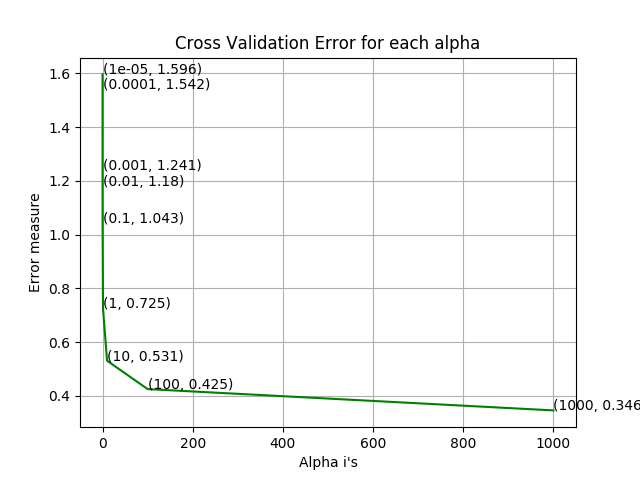

log loss for train data 0.3582194567195354
log loss for cv data 0.34574070777555804
log loss for test data 0.38127664030575664
Number of misclassified points  6.071757129714812
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


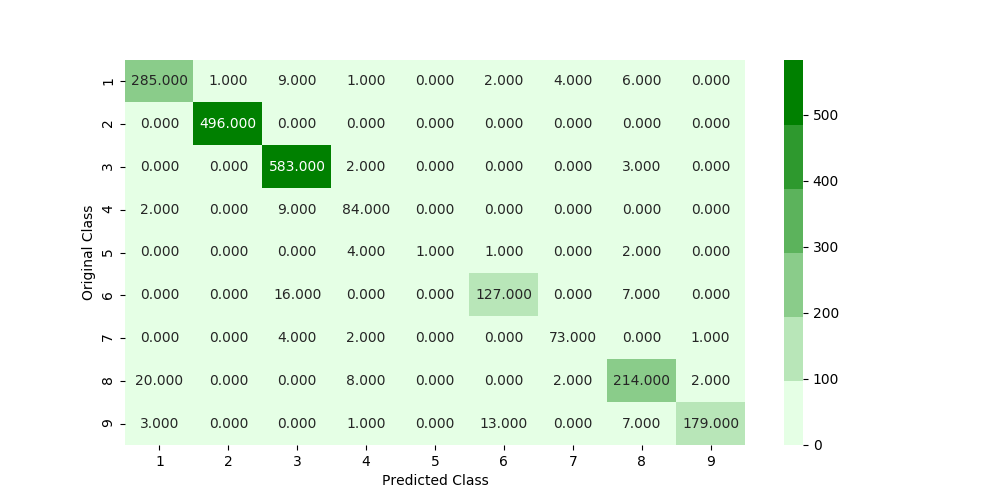

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


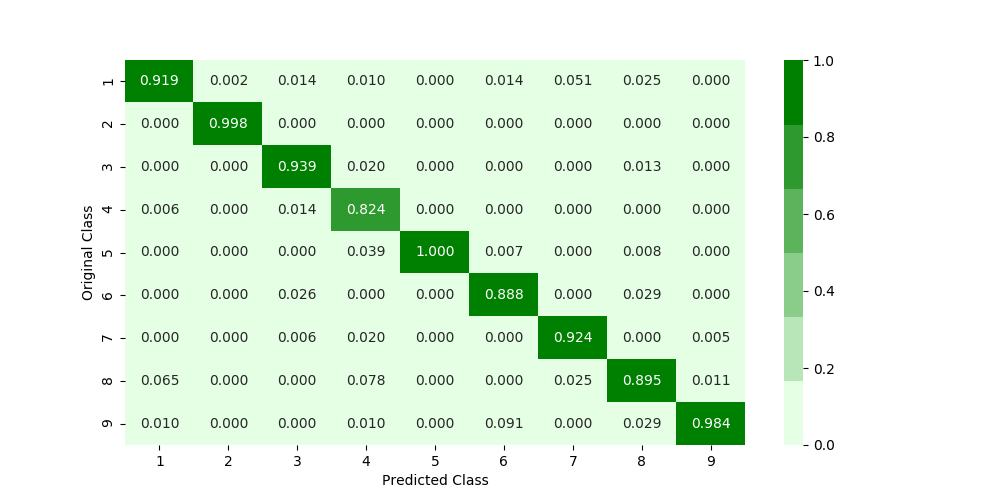

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


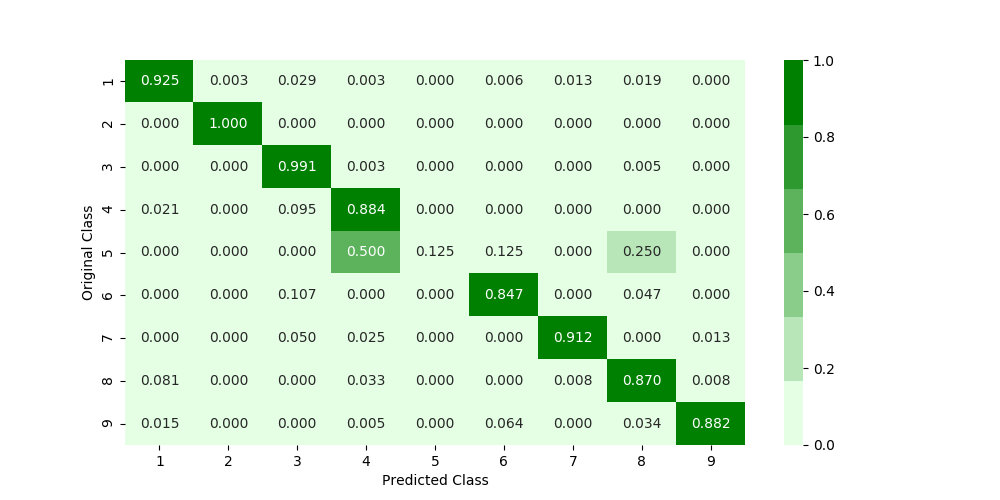

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [42]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
pred_y=sig_clf.predict(X_test)

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## Random Forest Classifier for ASM file

log_loss for c =  10 is 0.03999807015080344
log_loss for c =  50 is 0.033949818080554056
log_loss for c =  100 is 0.033822907839921236
log_loss for c =  500 is 0.033547421568465796
log_loss for c =  1000 is 0.03360559232499549
log_loss for c =  2000 is 0.03357052114859218
log_loss for c =  3000 is 0.033655496526623634


<IPython.core.display.Javascript object>


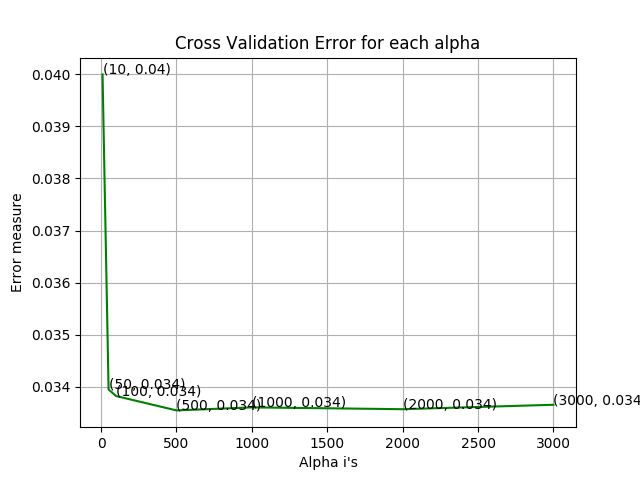

For values of best alpha =  500 The train log loss is: 0.02070627664890983
For values of best alpha =  500 The cross validation log loss is: 0.033547421568465796
For values of best alpha =  500 The test log loss is: 0.03701427018620628
Number of misclassified points  0.6899724011039559
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


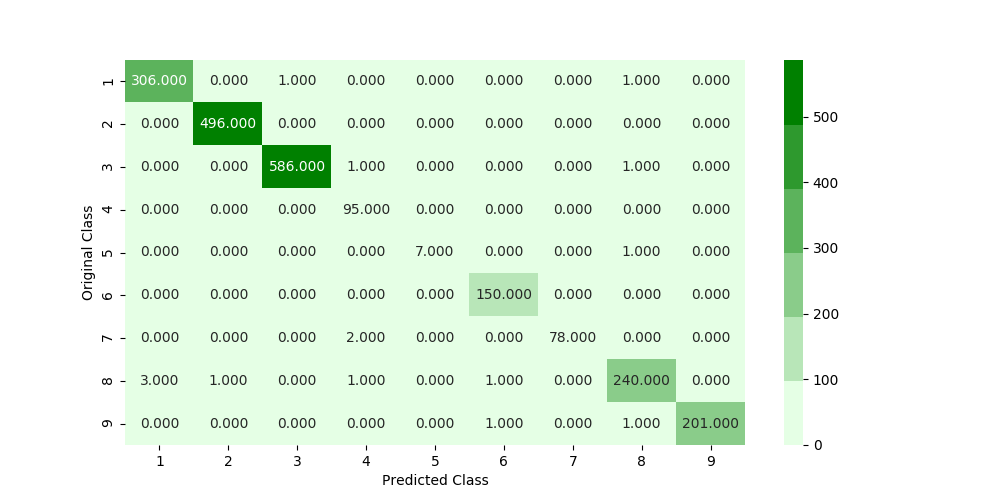

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


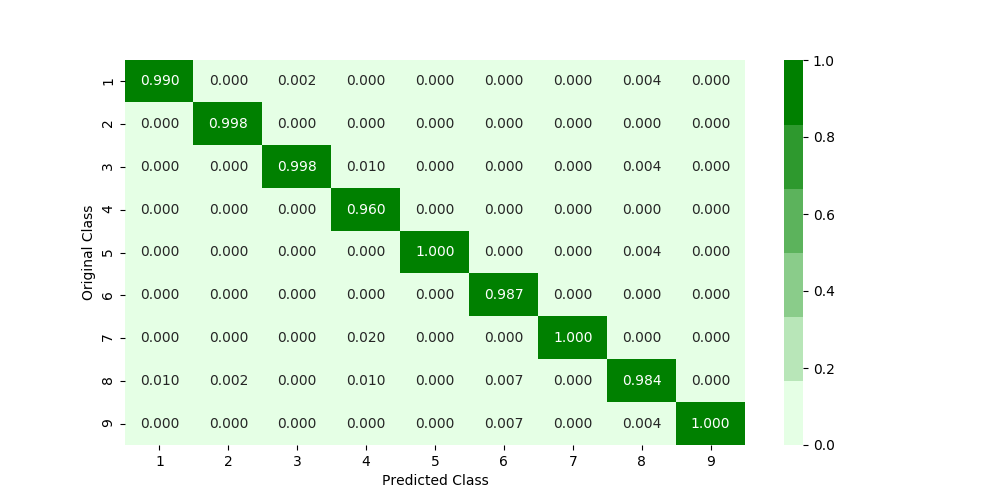

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


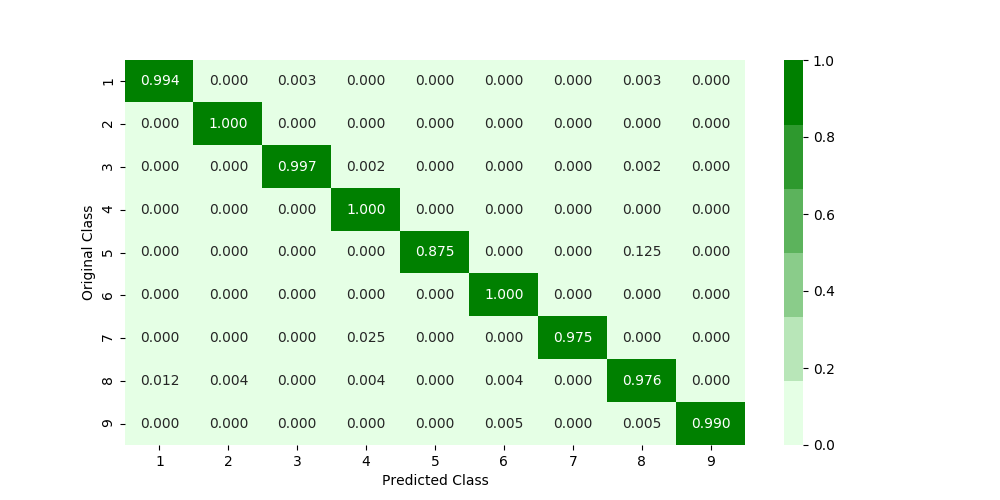

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [43]:

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## XG Boost + Hyperparameter Tuning for ASM file

In [44]:
data_y = result_asm['Class']

X_train, X_test, y_train, y_test = train_test_split(result_asm.drop(['ID','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)

print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])

Number of data points in train data: 8694
Number of data points in test data: 2174


In [16]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1)
random_cfl1.fit(X_train,y_train)
print("="*70)
print("Best Hyperparameters")
best = random_cfl1.best_params_
print (random_cfl1.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.8min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  2.0min remaining:   37.4s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  2.5min remaining:   16.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.0min finished


Best Hyperparameters
{'colsample_bytree': 0.5, 'subsample': 0.5, 'n_estimators': 2000, 'learning_rate': 0.05, 'max_depth': 3}


train loss 0.015531250141819006
test loss 0.03218903324231802
Number of misclassified points  0.6439742410303588
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


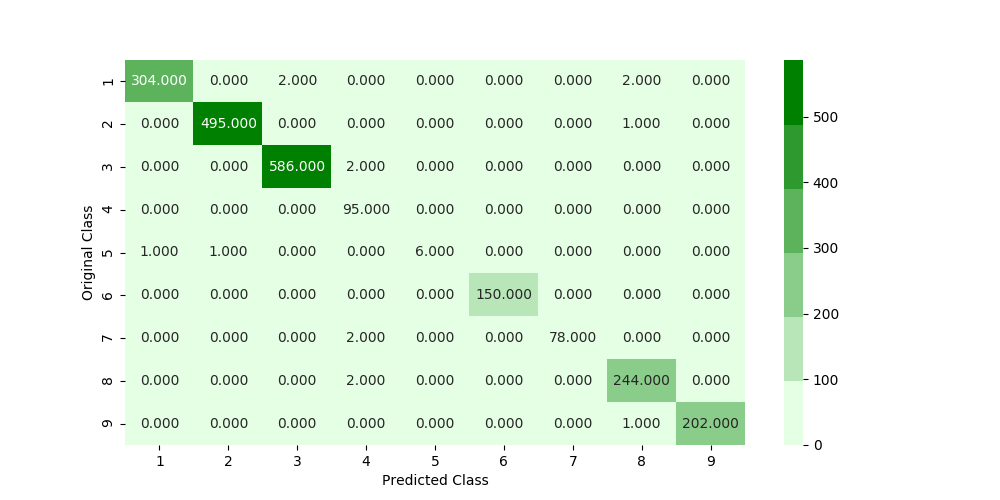

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


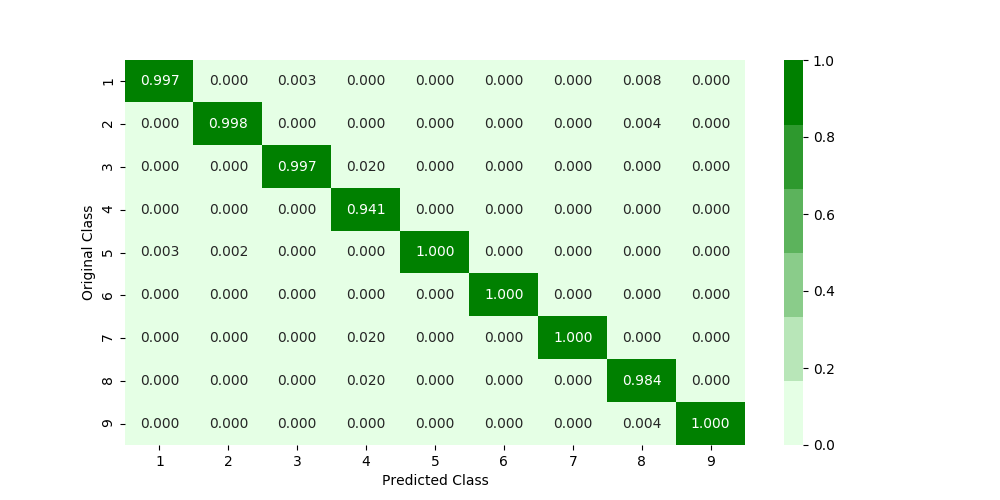

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


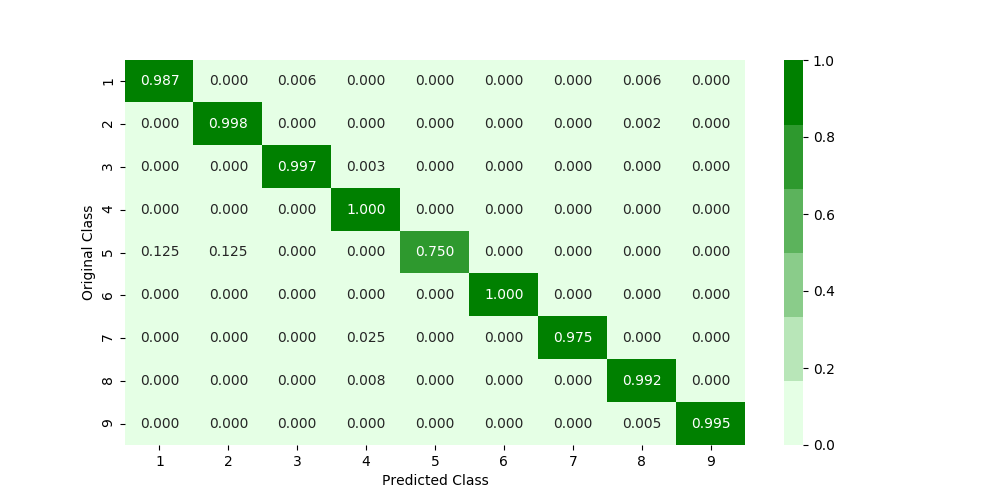

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [19]:
x_cfl=XGBClassifier(n_estimators=2000, learning_rate=0.05, colsample_bytree=0.5, max_depth=3, subsample=0.5, n_jobs=-1)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
#predict_y = c_cfl.predict_proba(X_cv)
#print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, c_cfl.predict(X_test))

# Opcodes ASM

In [17]:
opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']

opcode_bigram = []
for i, op in enumerate(opcodes):
    for j in range(len(opcodes)):
        opcode_bigram.append(op+" "+opcodes[j])
print(len(opcode_bigram))
        
opcode_trigram = []
for i, op in enumerate(opcodes):
    for j in range(len(opcodes)):
        for k in range(len(opcodes)):
            opcode_trigram.append(op+" "+opcodes[j]+" "+opcodes[k])
print(len(opcode_trigram))

676
17576


## Creating Text file of opcodes

In [33]:
op_file = open("opcode_file.txt","w+")
for asmfile in os.listdir('asmFiles'):
    opcode_str = ""
    with codecs.open('asmFiles/'+asmfile, encoding='cp1252', errors='replace') as file:
        for lines in file:
            line = lines.rstrip().split(" ")
            for li in line:
                if li in opcodes:
                    opcode_str += li+" "
    op_file.write(opcode_str + "\n")
op_file.close()
print('Complete...')

Complete...


### Collecting opcode text

In [6]:
raw_opcode = open("opcode_file.txt").read().split("\n")
print(len(raw_opcode))
print(raw_opcode[-1]) # we are using '\n' after every iteration so opcode_file.txt has 10869
                       # lines and last line is empty 
raw_opcode1 = raw_opcode[:10868]
print(len(raw_opcode1))

10869

10868


#### Creating a dataframe having opcode text and name of files 

In [7]:
opcode_data = pd.DataFrame()
opcode_data['ID'] = os.listdir("asmFiles")
opcode_data['text'] = raw_opcode1
opcode_data.head()

ID                                               text
0  0Hlm4XgE1cQhC6BkMays.asm  xor retn push lea sub mov mov push push push l...
1  EhSAMWFg7Uk5oqBfNlcC.asm  mov push push push call mov add or pop retn pu...
2  1Rr0hWX8Qz6nm3IgYLuF.asm  push mov sub push push push lea push pop mov p...
3  5cXoH4pnaQFISUNl1DsR.asm  mov push mov sub mov push push call pop push p...
4  HuqJS8CAp24F1aWeLtIo.asm  push push ror inc pop push push jmp jmp jmp jm...

## Defining ASM opcode Unigram 

In [4]:
vectorizer= CountVectorizer(ngram_range=(1,1))
opcode_unigram = vectorizer.fit_transform(opcode_data['text'].values)

print(opcode_unigram.shape)

(10868, 25)


In [8]:
uni_opcode = pd.DataFrame(opcode_unigram.todense(),columns = vectorizer.get_feature_names())
uni_opcode.head()

add  call   cmp  dec  imul  inc   jmp  jnb    jz  lea  ...  push  retf  \
0   102   141    98   35     4   53    47    8    58   86  ...   203     0   
1    48    95    45    2     1    5    22    3    34   25  ...   214     0   
2  1791  2265  2078   22    28   34  1286  116  1014  686  ...  5622     0   
3    97   136    12    2     0    1     0    0     2   40  ...   341     0   
4    43    25    48   52    17   10   107    0     3    3  ...   200    22   

   retn  rol  ror  shl  shr  sub  xchg  xor  
0   118    0    1   47   10   88     0   57  
1    38    0    0    3    1   11     0   35  
2   425    7    7  125   34  426     2  463  
3    46    0    0    0    0   50     1    9  
4     4    3   15    1   18   10    20   11  

[5 rows x 25 columns]

In [9]:
uni_opcode['ID'] = opcode_data['ID']
uni_opcode.to_csv("opcode_unigram.csv")

### Defining ASM opcode Bigram 

In [10]:
vectorizer2= CountVectorizer(ngram_range=(2,2))
opcode_bigram = vectorizer2.fit_transform(opcode_data['text'].values)
print(opcode_bigram.shape)

(10868, 625)


In [11]:
bi_opcode = pd.DataFrame(opcode_bigram.todense(),columns = vectorizer2.get_feature_names())
bi_opcode.head()

add add  add call  add cmp  add dec  add imul  add inc  add jmp  add jnb  \
0        3         0        5        4         0        2        1        0   
1        3         0       11        0         0        0        0        0   
2       15        28      312        0         0        0       46        2   
3        1         0        0        0         0        0        0        0   
4        7         1        1        0         0        0        4        0   

   add jz  add lea  ...  xor push  xor retf  xor retn  xor rol  xor ror  \
0       1        0  ...         2         0         4        0        0   
1       4        0  ...         2         0         2        0        0   
2      45       11  ...        54         0         2        1        1   
3       0        0  ...         5         0         0        0        0   
4       0        0  ...         1         2         0        1        0   

   xor shl  xor shr  xor sub  xor xchg  xor xor  
0        0        0        3         0        3  
1        0        0        0         0        2  
2        1        1        2         0       53  
3        0        0        0         0        0  
4        0        0        0         3        0  

[5 rows x 625 columns]

In [12]:
bi_opcode['ID'] = opcode_data['ID']
bi_opcode.to_csv("opcode_bigram.csv")

## Defining ASM opcode Trigram 

In [13]:
vectorizer3= CountVectorizer(ngram_range=(3,3))
opcode_trigram = vectorizer3.fit_transform(opcode_data['text'].values)
print(opcode_trigram.shape)

(10868, 14423)


In [14]:
tri_opcode = pd.DataFrame(opcode_trigram.todense(),columns =vectorizer3.get_feature_names())
tri_opcode.head()

add add add  add add call  add add cmp  add add dec  add add imul  \
0            1             0            0            0             0   
1            1             0            2            0             0   
2            0             0            6            0             0   
3            0             0            0            0             0   
4            1             0            0            0             0   

   add add inc  add add jmp  add add jnb  add add jz  add add lea  ...  \
0            1            0            0           1            0  ...   
1            0            0            0           0            0  ...   
2            0            4            0           0            0  ...   
3            0            0            0           0            0  ...   
4            0            2            0           0            0  ...   

   xor xor push  xor xor retf  xor xor retn  xor xor rol  xor xor ror  \
0             0             0             0            0            0   
1             1             0             0            0            0   
2            38             0             1            0            0   
3             0             0             0            0            0   
4             0             0             0            0            0   

   xor xor shl  xor xor shr  xor xor sub  xor xor xchg  xor xor xor  
0            0            0            0             0            0  
1            0            0            0             0            0  
2            0            0            0             0            7  
3            0            0            0             0            0  
4            0            0            0             0            0  

[5 rows x 14423 columns]

In [15]:
tri_opcode['ID'] = opcode_data['ID']
tri_opcode.to_csv("opcode_trigram.csv")

## Defining ASM opcode Quadgram 

In [8]:
vectorizer4= CountVectorizer(ngram_range=(4,4))
opcode_quadgram = vectorizer4.fit_transform(opcode_data['text'].values)
print(opcode_quadgram.shape)

(10868, 190882)


In [12]:
quad_opcode = pd.DataFrame(opcode_quadgram.todense(),columns =vectorizer4.get_feature_names())
quad_opcode['ID'] = opcode_data['ID']
quad_opcode.head()

add add add add  add add add call  add add add cmp  add add add dec  \
0                0                 0                0                0   
1                0                 0                1                0   
2                0                 0                0                0   
3                0                 0                0                0   
4                0                 0                0                0   

   add add add imul  add add add inc  add add add jmp  add add add jnb  \
0                 0                0                0                0   
1                 0                0                0                0   
2                 0                0                0                0   
3                 0                0                0                0   
4                 0                0                0                0   

   add add add jz  add add add lea  ...  xor xor xor retf  xor xor xor retn  \
0               1                0  ...                 0                 0   
1               0                0  ...                 0                 0   
2               0                0  ...                 0                 0   
3               0                0  ...                 0                 0   
4               0                0  ...                 0                 0   

   xor xor xor rol  xor xor xor ror  xor xor xor shl  xor xor xor shr  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   xor xor xor sub  xor xor xor xchg  xor xor xor xor  \
0                0                 0                0   
1                0                 0                0   
2                0                 0                4   
3                0                 0                0   
4                0                 0                0   

                         ID  
0  0Hlm4XgE1cQhC6BkMays.asm  
1  EhSAMWFg7Uk5oqBfNlcC.asm  
2  1Rr0hWX8Qz6nm3IgYLuF.asm  
3  5cXoH4pnaQFISUNl1DsR.asm  
4  HuqJS8CAp24F1aWeLtIo.asm  

[5 rows x 190883 columns]

### Taking top 2000 features of Opcode Quad gram

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

data_y = result['Class']
X = opcode_quadgram#.drop(['ID'], axis=1)

chi_feature=SelectKBest(chi2, k=2000)
best_opcode=chi_feature.fit_transform(X, data_y)
print(best_opcode.shape)

(10868, 2000)


In [20]:
quad_opcode = pd.DataFrame(best_opcode.todense())
quad_opcode['ID'] = opcode_data['ID']
quad_opcode.head()

0  1  2  3  4  5  6  7  8  9  ...  1991  1992  1993  1994  1995  1996  \
0  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2  0  0  0  0  0  3  0  0  0  0  ...     0     0     0     0     0     0   
3  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
4  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

   1997  1998  1999                        ID  
0     0     0     0  0Hlm4XgE1cQhC6BkMays.asm  
1     0     0     0  EhSAMWFg7Uk5oqBfNlcC.asm  
2     0     0     4  1Rr0hWX8Qz6nm3IgYLuF.asm  
3     0     0     0  5cXoH4pnaQFISUNl1DsR.asm  
4     0     0     0  HuqJS8CAp24F1aWeLtIo.asm  

[5 rows x 2001 columns]

In [21]:
quad_opcode.to_csv("opcode_quadgram.csv")

In [14]:
Y=pd.read_csv("trainLabels.csv")
Y['ID'] = Y['Id']+".asm"

In [39]:
uni_opcode= pd.read_csv("opcode_unigram.csv")
result = pd.merge(Y, uni_opcode,on='ID', how='left')
result = result.drop(['Id'], axis=1)
uni_opcode.head()

Unnamed: 0   add  call   cmp  dec  imul  inc   jmp  jnb    jz  ...  retf  \
0           0   102   141    98   35     4   53    47    8    58  ...     0   
1           1    48    95    45    2     1    5    22    3    34  ...     0   
2           2  1791  2265  2078   22    28   34  1286  116  1014  ...     0   
3           3    97   136    12    2     0    1     0    0     2  ...     0   
4           4    43    25    48   52    17   10   107    0     3  ...    22   

   retn  rol  ror  shl  shr  sub  xchg  xor                        ID  
0   118    0    1   47   10   88     0   57  0Hlm4XgE1cQhC6BkMays.asm  
1    38    0    0    3    1   11     0   35  EhSAMWFg7Uk5oqBfNlcC.asm  
2   425    7    7  125   34  426     2  463  1Rr0hWX8Qz6nm3IgYLuF.asm  
3    46    0    0    0    0   50     1    9  5cXoH4pnaQFISUNl1DsR.asm  
4     4    3   15    1   18   10    20   11  HuqJS8CAp24F1aWeLtIo.asm  

[5 rows x 27 columns]

In [25]:
result = result.drop(['Id'],axis=1)
result.head()

Class                        ID  Unnamed: 0       add      call       cmp  \
0      1  01kcPWA9K2BOxQeS5Rju.asm    0.545321  0.000442  0.001363  0.000805   
1      1  04EjIdbPV5e1XroFOpiN.asm    0.701482  0.014316  0.074600  0.085101   
2      1  05EeG39MTRrI6VY21DPd.asm    0.935125  0.007078  0.011859  0.017611   
3      1  05rJTUWYAKNegBk2wE8X.asm    0.755866  0.048820  0.274888  0.380295   
4      1  0AnoOZDNbPXIr2MRBSCJ.asm    0.192141  0.021394  0.011885  0.028940   

        dec      imul       inc       jmp  ...      push      retf      retn  \
0  0.000547  0.000000  0.000193  0.000604  ...  0.000838  0.000000  0.001061   
1  0.052891  0.000723  0.009443  0.074305  ...  0.061324  0.000000  0.050882   
2  0.001277  0.000193  0.000193  0.007300  ...  0.009467  0.000000  0.017315   
3  0.118001  0.000530  0.058296  0.231826  ...  0.296120  0.000851  0.154637   
4  0.000365  0.000145  0.000193  0.012082  ...  0.008081  0.000851  0.015590   

   rol       ror       shl       shr       sub      xchg       xor  
0  0.0  0.000000  0.000064  0.000000  0.000377  0.000000  0.000425  
1  0.0  0.000000  0.006127  0.004351  0.023461  0.000068  0.017459  
2  0.0  0.000000  0.000191  0.000692  0.005507  0.000000  0.004506  
3  0.0  0.000951  0.017040  0.037085  0.093543  0.000204  0.068468  
4  0.0  0.000000  0.005297  0.006824  0.016672  0.002581  0.005993  

[5 rows x 28 columns]

In [17]:
data_y = result['Class']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result.drop(['ID','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739


### Random Forest Classifier on Opcode Unigram 

log_loss for c =  10 is 0.10186729943666022
log_loss for c =  50 is 0.09918452497015852
log_loss for c =  100 is 0.09939797917405759
log_loss for c =  500 is 0.09783190462559592
log_loss for c =  1000 is 0.09818441742115774
log_loss for c =  2000 is 0.09810072984554202
log_loss for c =  3000 is 0.0982886960100237


<IPython.core.display.Javascript object>


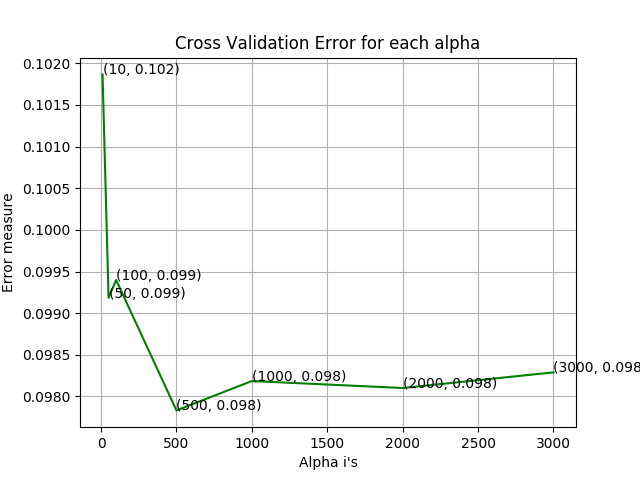

For values of best alpha =  500 The train log loss is: 0.028258071966743934
For values of best alpha =  500 The cross validation log loss is: 0.09783190462559592
For values of best alpha =  500 The test log loss is: 0.1035895986249567
Number of misclassified points  2.2539098436062557
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


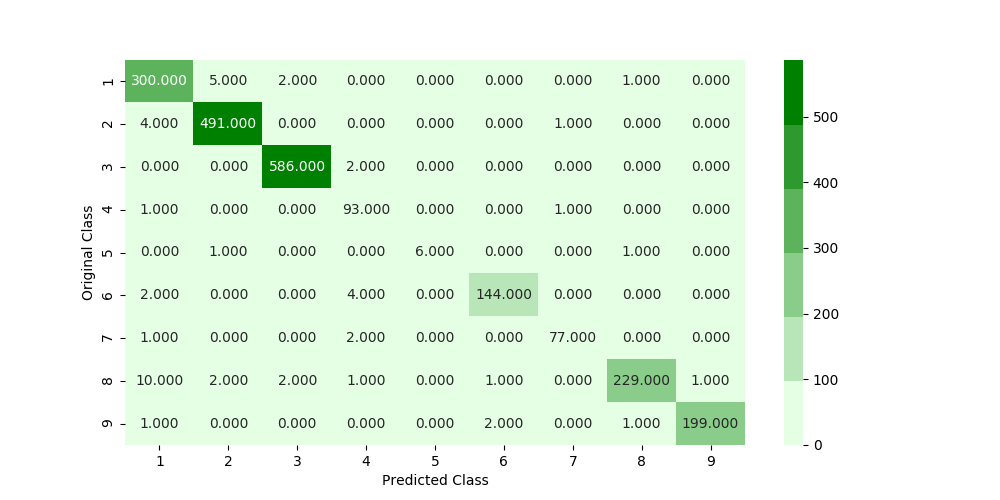

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


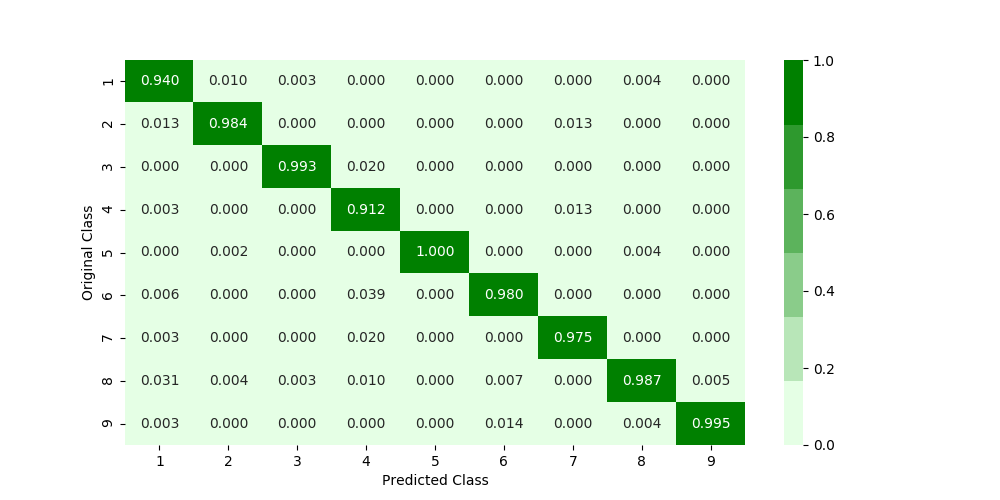

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


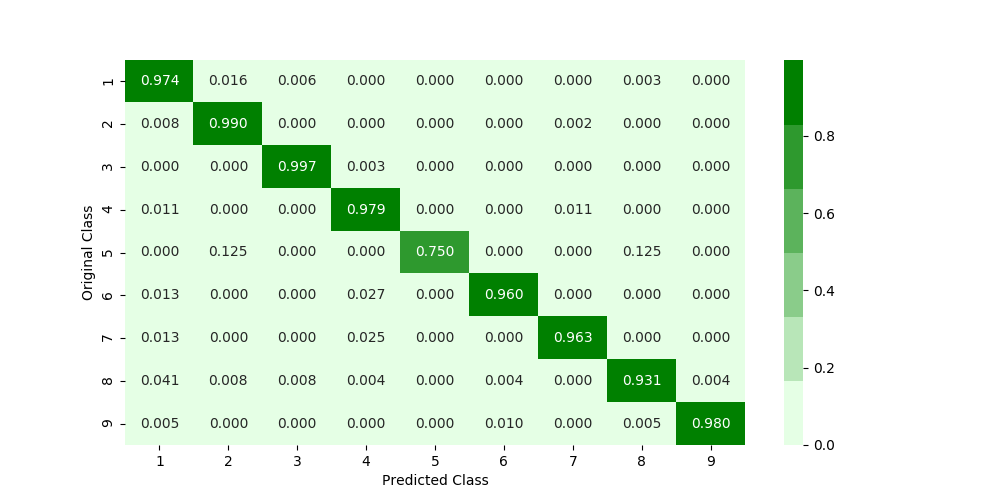

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [31]:

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## XG Boost on opcode unigram

log_loss for c =  10 is 0.25319925035141505
log_loss for c =  50 is 0.15199766386619676
log_loss for c =  100 is 0.11484660267809715
log_loss for c =  500 is 0.10138181242048533
log_loss for c =  1000 is 0.10214212468924305
log_loss for c =  2000 is 0.1030845940177203


<IPython.core.display.Javascript object>


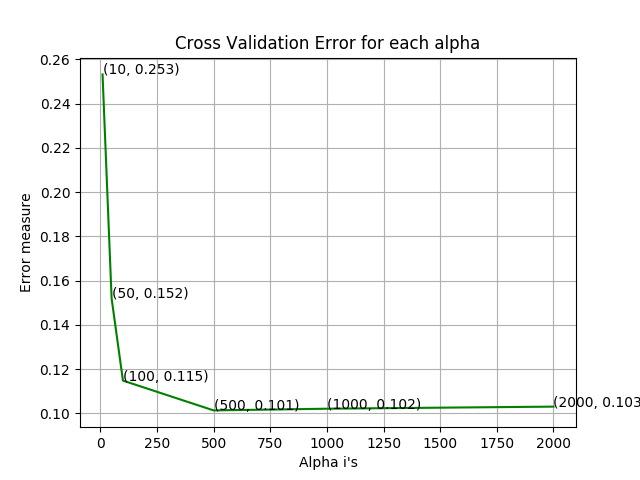

For values of best alpha =  500 The train log loss is: 0.027273377382320288
For values of best alpha =  500 The cross validation log loss is: 0.10138181242048533
For values of best alpha =  500 The test log loss is: 0.11614312638696182
Number of misclassified points  2.3459061637534497
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


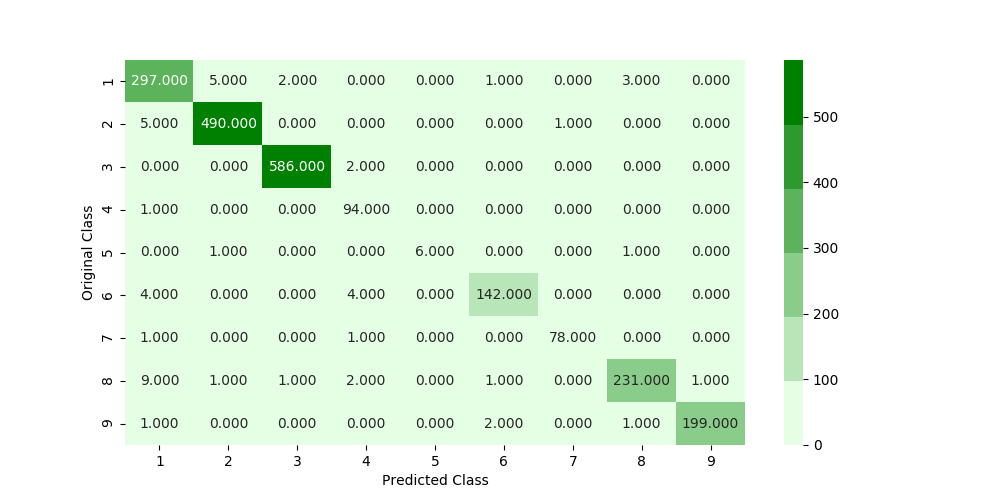

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


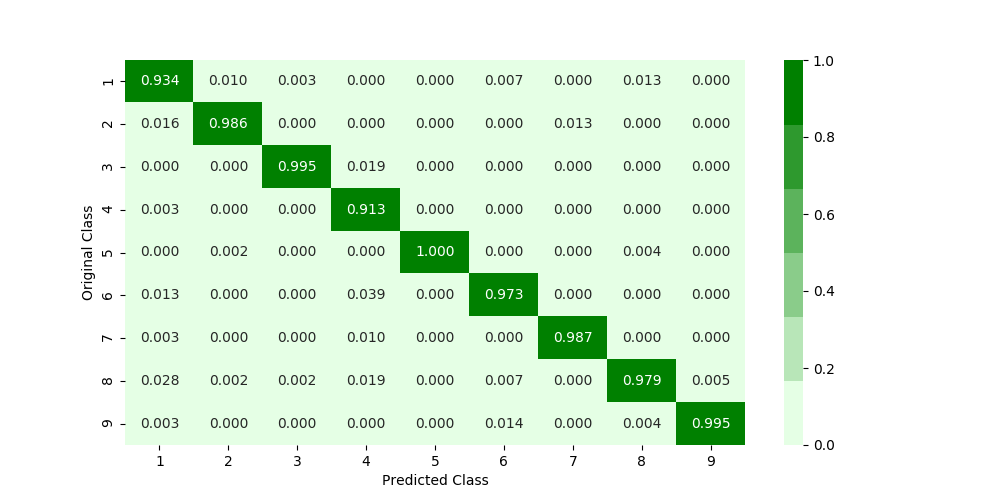

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


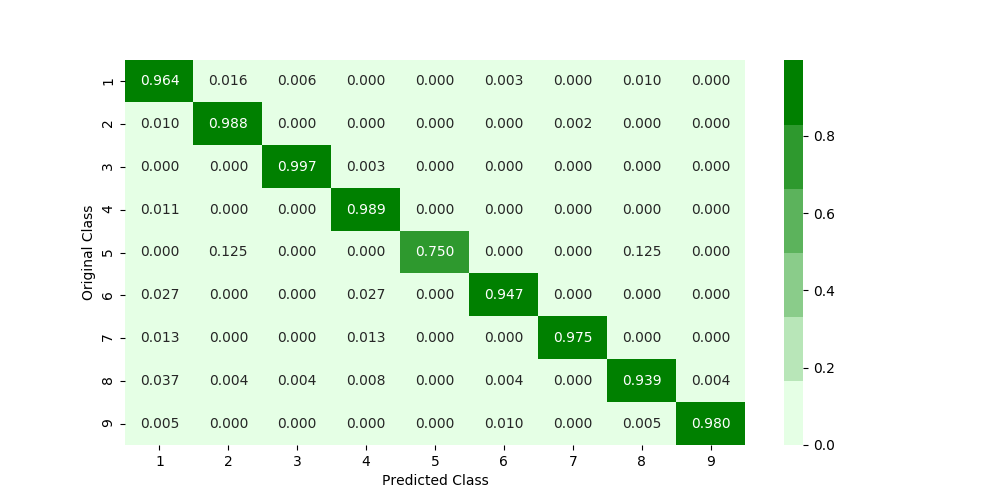

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [33]:
alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1, n_jobs=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

In [5]:
uni_opcode= pd.read_csv("opcode_unigram.csv")
bi_opcode= pd.read_csv("opcode_bigram.csv")
result1 = pd.merge(Y, uni_opcode,on='ID', how='left')
result1 = result1.drop(['Id'],axis=1)
result = pd.merge(result1, bi_opcode, on='ID', how='left')
result = normalize(result)
result.head()

Class                        ID  Unnamed: 0_x       add      call  \
0      1  01kcPWA9K2BOxQeS5Rju.asm      0.545321  0.000442  0.001363   
1      1  04EjIdbPV5e1XroFOpiN.asm      0.701482  0.014316  0.074600   
2      1  05EeG39MTRrI6VY21DPd.asm      0.935125  0.007078  0.011859   
3      1  05rJTUWYAKNegBk2wE8X.asm      0.755866  0.048820  0.274888   
4      1  0AnoOZDNbPXIr2MRBSCJ.asm      0.192141  0.021394  0.011885   

        cmp       dec      imul       inc       jmp  ...  xor push  xor retf  \
0  0.000805  0.000547  0.000000  0.000193  0.000604  ...  0.000000       0.0   
1  0.085101  0.052891  0.000723  0.009443  0.074305  ...  0.037404       0.0   
2  0.017611  0.001277  0.000193  0.000193  0.007300  ...  0.011717       0.0   
3  0.380295  0.118001  0.000530  0.058296  0.231826  ...  0.138801       0.0   
4  0.028940  0.000365  0.000145  0.000193  0.012082  ...  0.004056       0.0   

   xor retn  xor rol  xor ror   xor shl   xor shr   xor sub  xor xchg  \
0  0.000000      0.0      0.0  0.000000  0.000000  0.000000  0.000000   
1  0.013536      0.0      0.0  0.000000  0.000000  0.005122  0.000000   
2  0.008460      0.0      0.0  0.000000  0.000000  0.003841  0.000000   
3  0.054146      0.0      0.0  0.000427  0.010008  0.014085  0.000000   
4  0.020305      0.0      0.0  0.000000  0.000000  0.008963  0.010968   

    xor xor  
0  0.000093  
1  0.001211  
2  0.000559  
3  0.007735  
4  0.000559  

[5 rows x 654 columns]

In [40]:
bi_opcode= pd.read_csv("opcode_bigram.csv")
tri_opcode = pd.read_csv("opcode_trigram.csv")

In [41]:
bi_opcode.shape, tri_opcode.shape

((10868, 627), (10868, 14425))

In [6]:
data_y = result['Class']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result.drop(['ID','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739


## Random Forest Classifier on Opcode Bigram

log_loss for c =  10 is 0.09820969336118192
log_loss for c =  50 is 0.09342411327809207
log_loss for c =  100 is 0.0939578257008347
log_loss for c =  500 is 0.09300747234080557
log_loss for c =  1000 is 0.0928934523695283
log_loss for c =  2000 is 0.09297441206813409
log_loss for c =  3000 is 0.09280103185749006


<IPython.core.display.Javascript object>


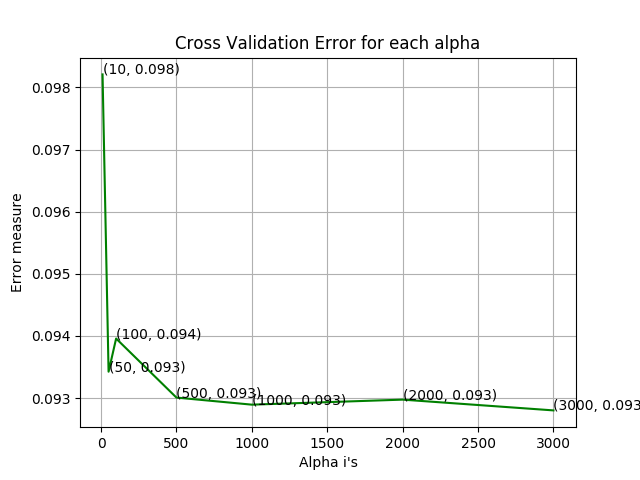

For values of best alpha =  3000 The train log loss is: 0.023668538281422173
For values of best alpha =  3000 The cross validation log loss is: 0.09280103185749006
For values of best alpha =  3000 The test log loss is: 0.07865984160430257
Number of misclassified points  1.5639374425023
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


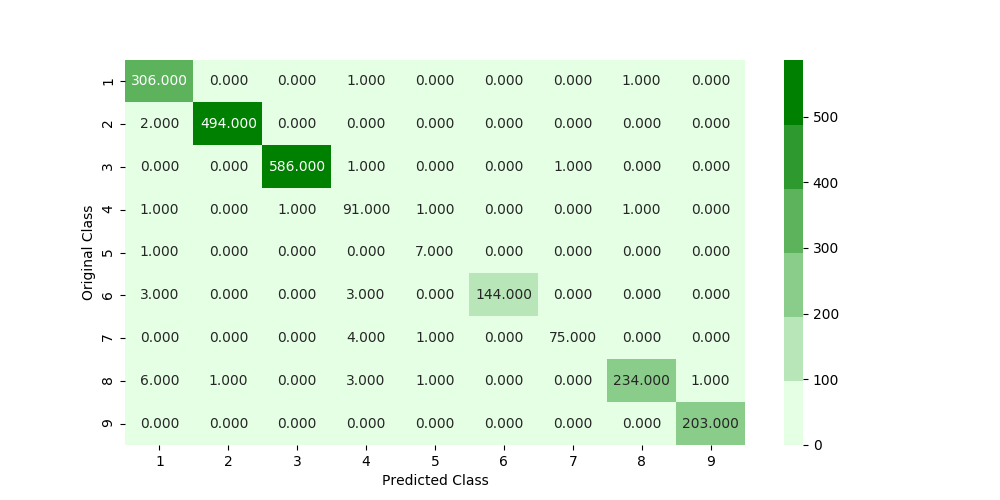

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


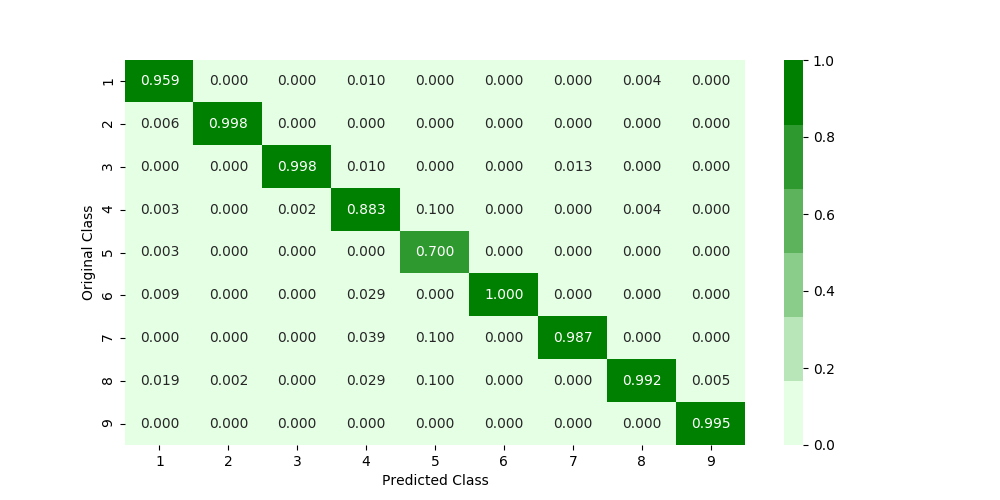

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


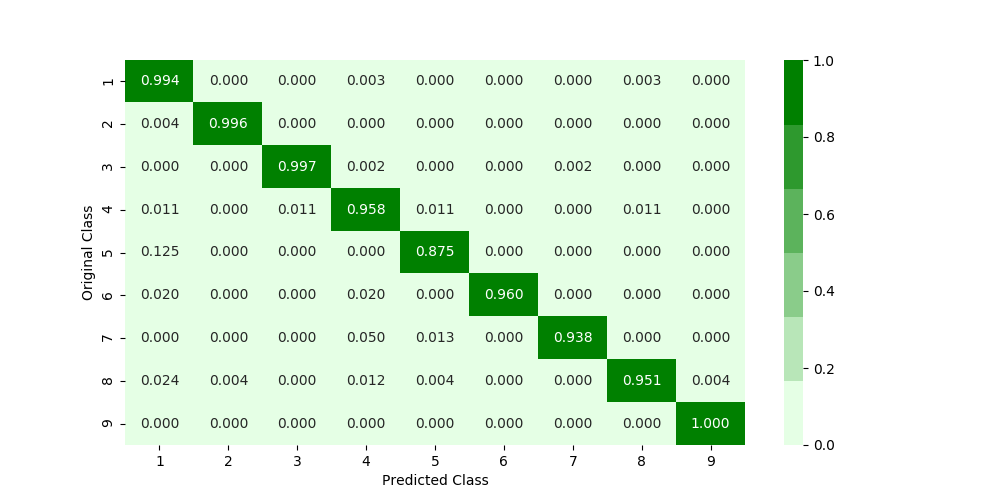

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [9]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

In [13]:
tri_opcode= pd.read_csv("opcode_trigram.csv")
result = pd.merge(Y, tri_opcode, on='ID', how='left')
result = result.drop(['Id'],axis=1)
#result = normalize(result)
result.head()

Class                        ID  Unnamed: 0  add add add  add add call  \
0      1  01kcPWA9K2BOxQeS5Rju.asm        5926            0             0   
1      1  04EjIdbPV5e1XroFOpiN.asm        7623            2             0   
2      1  05EeG39MTRrI6VY21DPd.asm       10162            0             0   
3      1  05rJTUWYAKNegBk2wE8X.asm        8214            3             0   
4      1  0AnoOZDNbPXIr2MRBSCJ.asm        2088            6             0   

   add add cmp  add add dec  add add imul  add add inc  add add jmp  ...  \
0            0            0             0            0            0  ...   
1            0            3             0            0            1  ...   
2            1            0             0            0            0  ...   
3           13            0             0            1            5  ...   
4           19            0             0            0            3  ...   

   xor xor push  xor xor retf  xor xor retn  xor xor rol  xor xor ror  \
0             0             0             0            0            0   
1             2             0             0            0            0   
2             1             0             0            0            0   
3             2             0             0            0            0   
4             1             0             0            0            0   

   xor xor shl  xor xor shr  xor xor sub  xor xor xchg  xor xor xor  
0            0            0            0             0            0  
1            0            0            0             0            0  
2            0            0            1             0            1  
3            0            0            0             0           10  
4            0            0            0             0            0  

[5 rows x 14426 columns]

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

data_y = result['Class']
X = result.drop(['ID','Class'], axis=1)

chi_feature=SelectKBest(chi2, k=600)
best_opcode=chi_feature.fit_transform(X, data_y)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(best_opcode, data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739


## Random Forest Classifier on Opcode Trigram for top 600 features

log_loss for c =  10 is 0.09864974472357298
log_loss for c =  50 is 0.0943614036840479
log_loss for c =  100 is 0.09392728562658705
log_loss for c =  500 is 0.09516545575912952
log_loss for c =  1000 is 0.09502617487270286
log_loss for c =  2000 is 0.0952851758601752
log_loss for c =  3000 is 0.09518146756515966


<IPython.core.display.Javascript object>


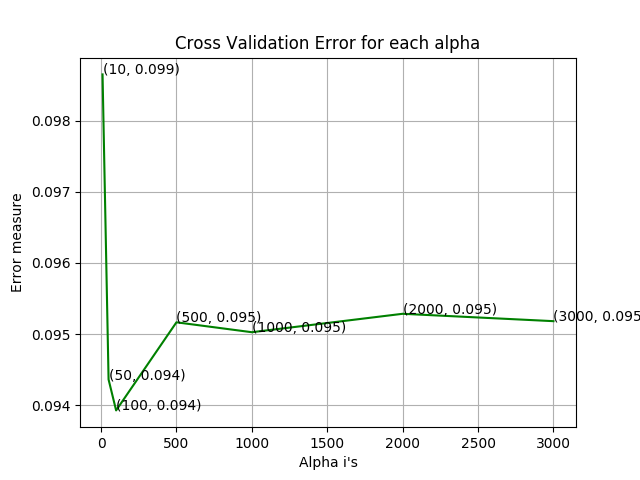

For values of best alpha =  100 The train log loss is: 0.04229838419026111
For values of best alpha =  100 The cross validation log loss is: 0.09392728562658705
For values of best alpha =  100 The test log loss is: 0.07085644640191294
Number of misclassified points  1.3799448022079117
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


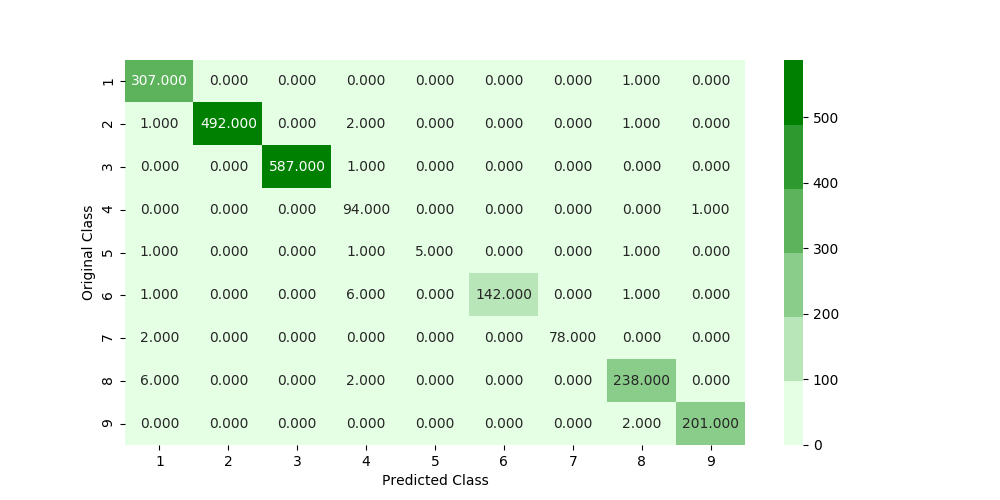

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


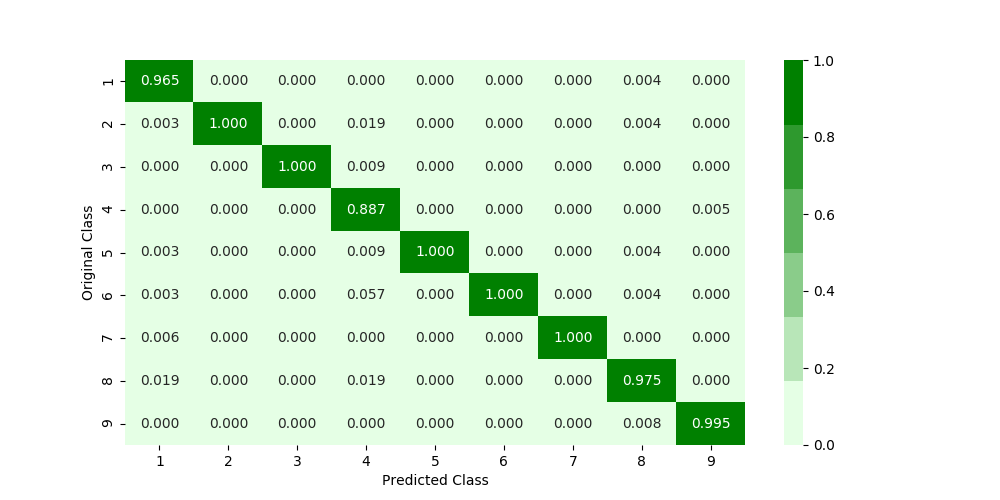

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


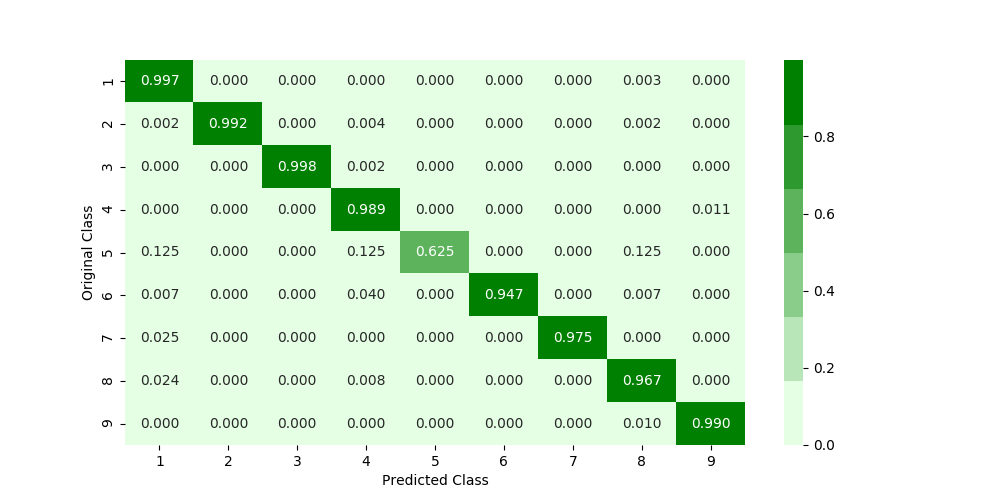

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [28]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

In [24]:
quad_opcode= pd.read_csv("opcode_quadgram.csv")
result = pd.merge(Y, quad_opcode,on='ID', how='left')
result = result.drop(['Id'], axis=1)
result = normalize(result)
result.head()

Class                        ID  Unnamed: 0         0    1    2    3    4  \
0      1  01kcPWA9K2BOxQeS5Rju.asm    0.545321  0.000000  0.0  0.0  0.0  0.0   
1      1  04EjIdbPV5e1XroFOpiN.asm    0.701482  0.000418  0.0  0.0  0.0  0.0   
2      1  05EeG39MTRrI6VY21DPd.asm    0.935125  0.000000  0.0  0.0  0.0  0.0   
3      1  05rJTUWYAKNegBk2wE8X.asm    0.755866  0.000000  0.0  0.0  0.0  0.0   
4      1  0AnoOZDNbPXIr2MRBSCJ.asm    0.192141  0.000418  0.0  0.0  0.0  0.0   

          5    6  ...      1990  1991  1992  1993  1994  1995      1996  1997  \
0  0.000000  0.0  ...  0.000000   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   
1  0.000000  0.0  ...  0.000000   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   
2  0.000000  0.0  ...  0.000000   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   
3  0.009740  0.0  ...  0.003125   0.0   0.0   0.0   0.0   0.0  0.000654   0.0   
4  0.003247  0.0  ...  0.000000   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   

   1998      1999  
0   0.0  0.000000  
1   0.0  0.000000  
2   0.0  0.000000  
3   0.0  0.002182  
4   0.0  0.000000  

[5 rows x 2003 columns]

In [27]:
data_y = result['Class']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result.drop(['ID','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739


## Random Forest Classifier on Opcode Quadgram for top 2000 features

log_loss for c =  10 is 0.09848803330275019
log_loss for c =  50 is 0.09865855117924856
log_loss for c =  100 is 0.10012973836796693
log_loss for c =  500 is 0.09949322940904685
log_loss for c =  1000 is 0.0995939502296073
log_loss for c =  2000 is 0.09894528000569829
log_loss for c =  3000 is 0.09918039320576409


<IPython.core.display.Javascript object>


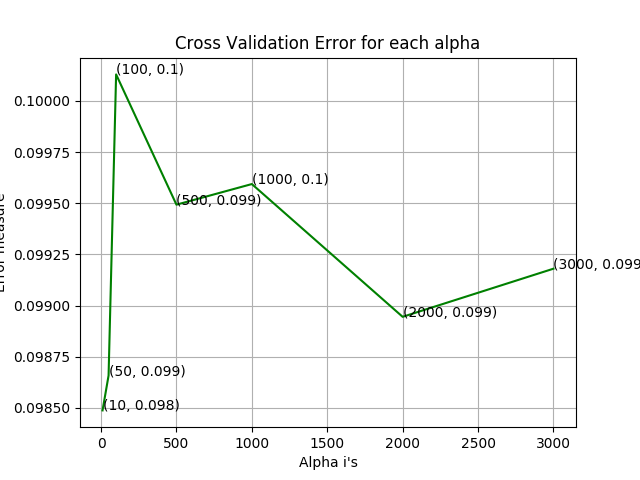

For values of best alpha =  10 The train log loss is: 0.03616206024250632
For values of best alpha =  10 The cross validation log loss is: 0.09848803330275019
For values of best alpha =  10 The test log loss is: 0.10719280988335957
Number of misclassified points  2.2999080036798527
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


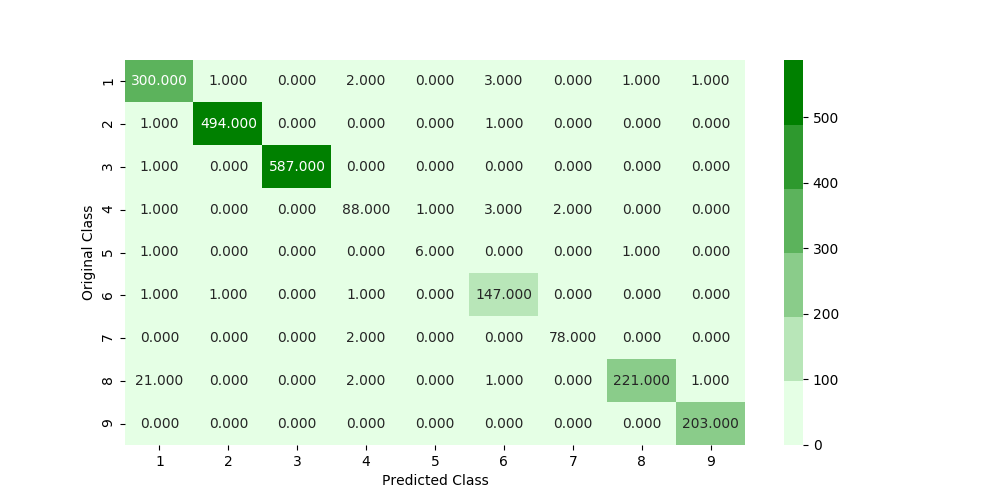

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


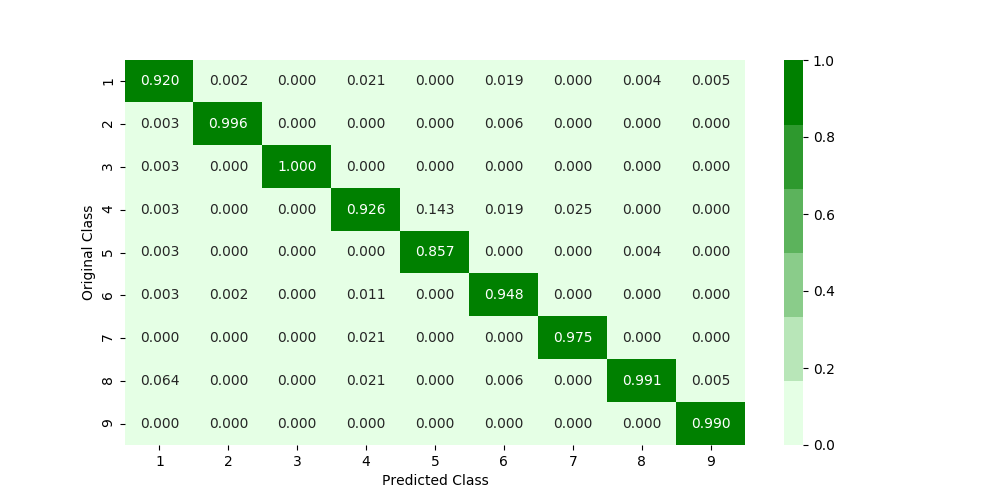

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


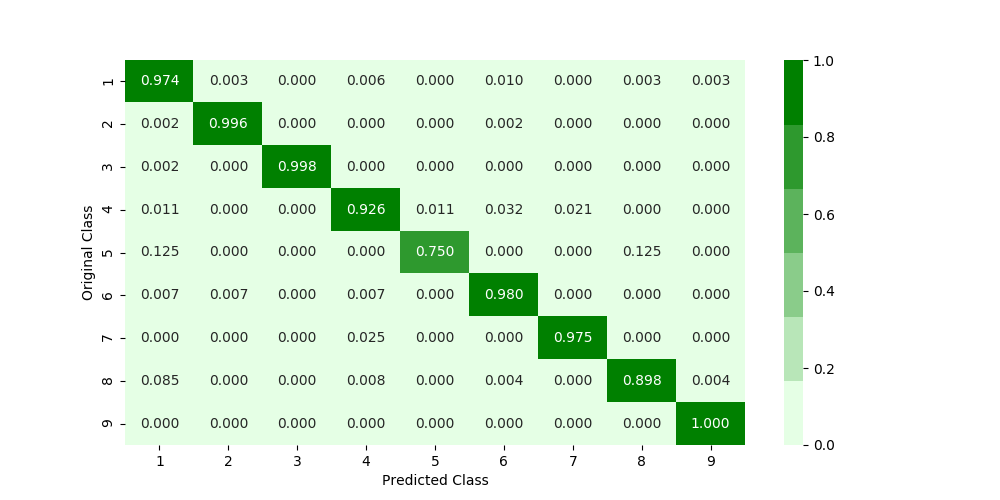

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [32]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## Image Features on ASM Files

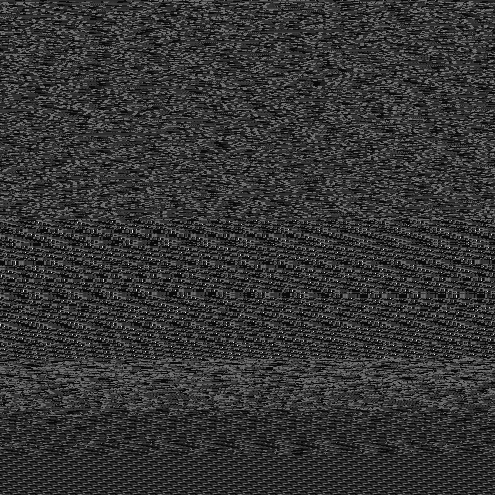

In [3]:
import scipy.misc
os.makedirs("asm_image")
files = os.listdir("asmFiles")

for asmfile in files:
    filename = asmfile.split('.')[0]
    file = codecs.open("asmFiles/"+asmfile, 'rb')
    filelen = os.path.getsize("asmFiles/"+asmfile)
    width = int(filelen**0.5)
    rem = int(filelen/width)
    arr = array.array('B')
    arr.frombytes(file.read())
    file.close()
    reshaped = np.reshape(arr[:width*width], (width, width))
    reshaped = np.uint8(reshaped)
    scipy.misc.imsave('asm_image/'+ filename + '.png', reshaped)

Image(filename="asm_image/deTXH9Zau7qmM0yfYsRS.png")

In [2]:
imagefeatures = np.zeros((10868, 200))
files = os.listdir("asmFiles")
for i, asmfile in tqdm(enumerate(files)):
    img = cv2.imread("asm_image/" + asmfile.split('.')[0] + '.png')
    img_arr = img.flatten()[:200]
    imagefeatures[i,:] += img_arr 

10868it [29:51,  6.07it/s]


In [7]:
imgfeatures_name = []
for i in range(200):
    imgfeatures_name.append('pix'+str(i))
imgdf = pd.DataFrame(imagefeatures, columns = imgfeatures_name)
imgdf['ID'] = files
imgdf.head()

pix0  pix1  pix2   pix3   pix4   pix5   pix6   pix7   pix8   pix9  ...  \
0  46.0  46.0  46.0  116.0  116.0  116.0  101.0  101.0  101.0  120.0  ...   
1  72.0  72.0  72.0   69.0   69.0   69.0   65.0   65.0   65.0   68.0  ...   
2  72.0  72.0  72.0   69.0   69.0   69.0   65.0   65.0   65.0   68.0  ...   
3  72.0  72.0  72.0   69.0   69.0   69.0   65.0   65.0   65.0   68.0  ...   
4  72.0  72.0  72.0   69.0   69.0   69.0   65.0   65.0   65.0   68.0  ...   

   pix191  pix192  pix193  pix194  pix195  pix196  pix197  pix198  pix199  \
0    45.0    45.0    45.0    45.0    45.0    45.0    45.0    45.0    45.0   
1    45.0    45.0    45.0    45.0    45.0    45.0    45.0    45.0    45.0   
2    45.0    45.0    45.0    45.0    45.0    45.0    45.0    45.0    45.0   
3    45.0    45.0    45.0    45.0    45.0    45.0    45.0    45.0    45.0   
4    45.0    45.0    45.0    45.0    45.0    45.0    45.0    45.0    45.0   

                         ID  
0  0Hlm4XgE1cQhC6BkMays.asm  
1  EhSAMWFg7Uk5oqBfNlcC.asm  
2  1Rr0hWX8Qz6nm3IgYLuF.asm  
3  5cXoH4pnaQFISUNl1DsR.asm  
4  HuqJS8CAp24F1aWeLtIo.asm  

[5 rows x 201 columns]

In [8]:
imgdf.to_csv('image_features.csv')

In [42]:
imgdf = pd.read_csv('image_features.csv')
imgdf.head()

Unnamed: 0  pix0  pix1  pix2   pix3   pix4   pix5   pix6   pix7   pix8  \
0           0  46.0  46.0  46.0  116.0  116.0  116.0  101.0  101.0  101.0   
1           1  72.0  72.0  72.0   69.0   69.0   69.0   65.0   65.0   65.0   
2           2  72.0  72.0  72.0   69.0   69.0   69.0   65.0   65.0   65.0   
3           3  72.0  72.0  72.0   69.0   69.0   69.0   65.0   65.0   65.0   
4           4  72.0  72.0  72.0   69.0   69.0   69.0   65.0   65.0   65.0   

   ...  pix191  pix192  pix193  pix194  pix195  pix196  pix197  pix198  \
0  ...    45.0    45.0    45.0    45.0    45.0    45.0    45.0    45.0   
1  ...    45.0    45.0    45.0    45.0    45.0    45.0    45.0    45.0   
2  ...    45.0    45.0    45.0    45.0    45.0    45.0    45.0    45.0   
3  ...    45.0    45.0    45.0    45.0    45.0    45.0    45.0    45.0   
4  ...    45.0    45.0    45.0    45.0    45.0    45.0    45.0    45.0   

   pix199                        ID  
0    45.0  0Hlm4XgE1cQhC6BkMays.asm  
1    45.0  EhSAMWFg7Uk5oqBfNlcC.asm  
2    45.0  1Rr0hWX8Qz6nm3IgYLuF.asm  
3    45.0  5cXoH4pnaQFISUNl1DsR.asm  
4    45.0  HuqJS8CAp24F1aWeLtIo.asm  

[5 rows x 202 columns]

In [11]:
imgdf = normalize(imgdf)
result = pd.merge(Y, imgdf, on='ID', how='left')
result = result.drop(['Id'], axis=1)
result.head()

Class                        ID  Unnamed: 0      pix0      pix1      pix2  \
0      1  01kcPWA9K2BOxQeS5Rju.asm    0.545321  0.481928  0.481928  0.481928   
1      1  04EjIdbPV5e1XroFOpiN.asm    0.701482  0.481928  0.481928  0.481928   
2      1  05EeG39MTRrI6VY21DPd.asm    0.935125  0.481928  0.481928  0.481928   
3      1  05rJTUWYAKNegBk2wE8X.asm    0.755866  0.481928  0.481928  0.481928   
4      1  0AnoOZDNbPXIr2MRBSCJ.asm    0.192141  0.481928  0.481928  0.481928   

       pix3      pix4      pix5  pix6  ...  pix190  pix191  pix192  pix193  \
0  0.302632  0.302632  0.302632   0.0  ...     1.0     1.0     1.0     1.0   
1  0.302632  0.302632  0.302632   0.0  ...     1.0     1.0     1.0     1.0   
2  0.302632  0.302632  0.302632   0.0  ...     1.0     1.0     1.0     1.0   
3  0.302632  0.302632  0.302632   0.0  ...     1.0     1.0     1.0     1.0   
4  0.302632  0.302632  0.302632   0.0  ...     1.0     1.0     1.0     1.0   

   pix194  pix195  pix196  pix197  pix198  pix199  
0     1.0     1.0     1.0     1.0     1.0     1.0  
1     1.0     1.0     1.0     1.0     1.0     1.0  
2     1.0     1.0     1.0     1.0     1.0     1.0  
3     1.0     1.0     1.0     1.0     1.0     1.0  
4     1.0     1.0     1.0     1.0     1.0     1.0  

[5 rows x 203 columns]

In [13]:
result = result.drop(['Unnamed: 0'], axis=1)

In [21]:
for i in result.columns:
    #print(result[i].isnull().sum())
    if result[i].isnull().sum() != 0:
        result.drop([i], axis=1, inplace=True)
result.head()

Class                        ID      pix0      pix1      pix2      pix3  \
0      1  01kcPWA9K2BOxQeS5Rju.asm  0.481928  0.481928  0.481928  0.302632   
1      1  04EjIdbPV5e1XroFOpiN.asm  0.481928  0.481928  0.481928  0.302632   
2      1  05EeG39MTRrI6VY21DPd.asm  0.481928  0.481928  0.481928  0.302632   
3      1  05rJTUWYAKNegBk2wE8X.asm  0.481928  0.481928  0.481928  0.302632   
4      1  0AnoOZDNbPXIr2MRBSCJ.asm  0.481928  0.481928  0.481928  0.302632   

       pix4      pix5  pix6  pix7  ...  pix190  pix191  pix192  pix193  \
0  0.302632  0.302632   0.0   0.0  ...     1.0     1.0     1.0     1.0   
1  0.302632  0.302632   0.0   0.0  ...     1.0     1.0     1.0     1.0   
2  0.302632  0.302632   0.0   0.0  ...     1.0     1.0     1.0     1.0   
3  0.302632  0.302632   0.0   0.0  ...     1.0     1.0     1.0     1.0   
4  0.302632  0.302632   0.0   0.0  ...     1.0     1.0     1.0     1.0   

   pix194  pix195  pix196  pix197  pix198  pix199  
0     1.0     1.0     1.0     1.0     1.0     1.0  
1     1.0     1.0     1.0     1.0     1.0     1.0  
2     1.0     1.0     1.0     1.0     1.0     1.0  
3     1.0     1.0     1.0     1.0     1.0     1.0  
4     1.0     1.0     1.0     1.0     1.0     1.0  

[5 rows x 196 columns]

In [22]:
result.isnull().sum().sum()

0

In [23]:
data_y = result['Class']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result.drop(['ID','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739


## Random Forest Classifier on Image Features

log_loss for c =  10 is 1.0209652107271674
log_loss for c =  50 is 1.0209389845384698
log_loss for c =  100 is 1.02092486659487
log_loss for c =  500 is 1.0211074993903277
log_loss for c =  1000 is 1.0211889127205211
log_loss for c =  2000 is 1.021280397481048
log_loss for c =  3000 is 1.0211496083679683


<IPython.core.display.Javascript object>


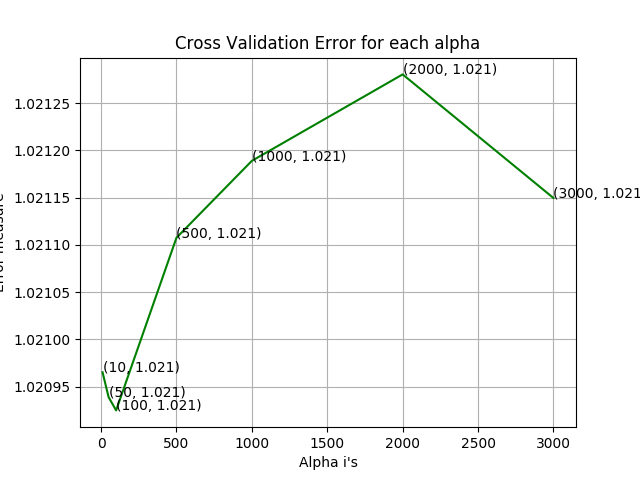

For values of best alpha =  100 The train log loss is: 1.0191078181276978
For values of best alpha =  100 The cross validation log loss is: 1.02092486659487
For values of best alpha =  100 The test log loss is: 1.0474579077702284
Number of misclassified points  38.362465501379944
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


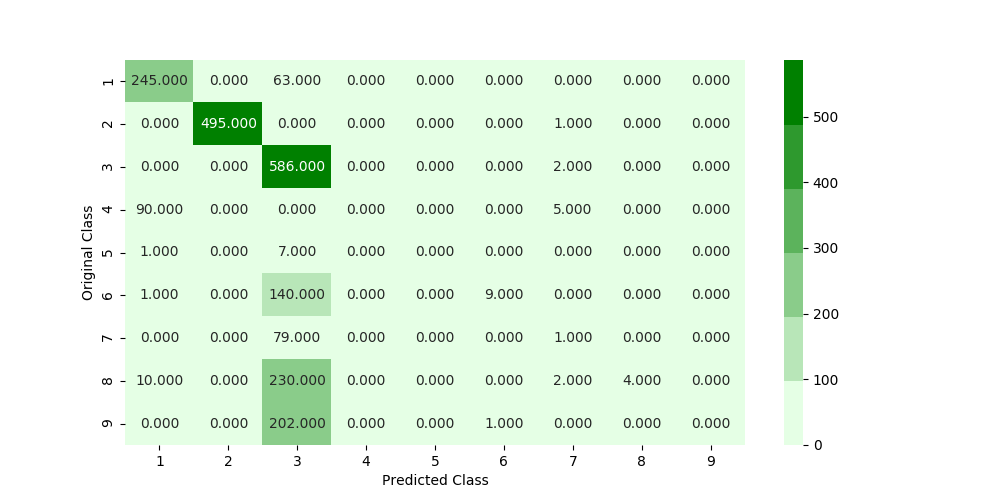

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


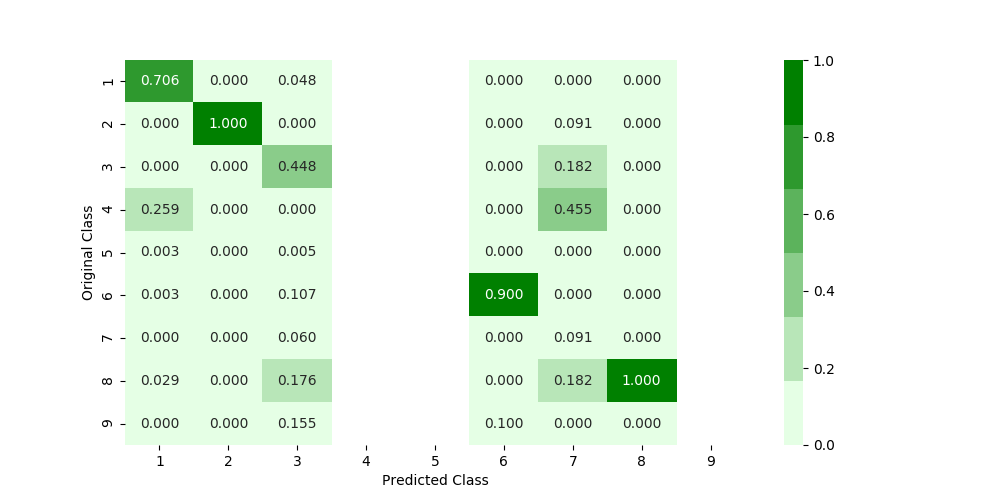

Sum of columns in precision matrix [ 1.  1.  1. nan nan  1.  1.  1. nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


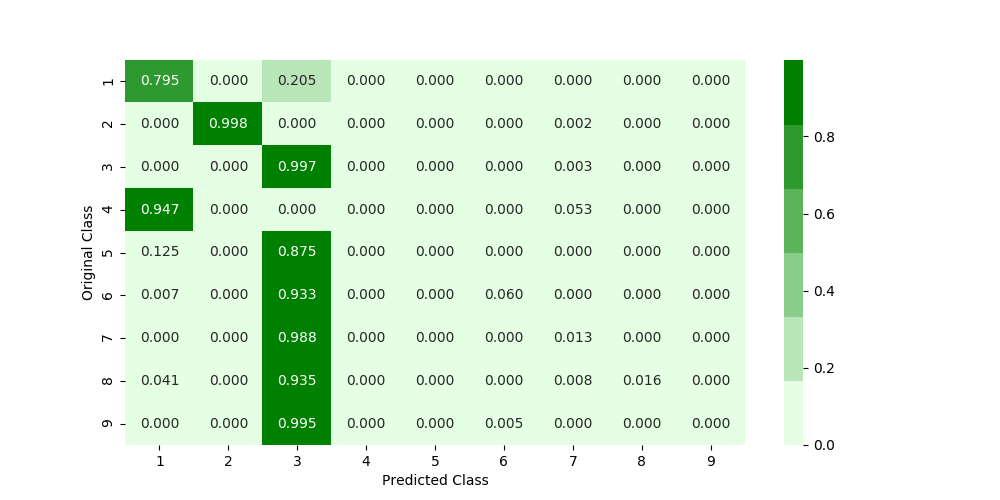

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [24]:

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## Merging models

In [49]:
for i in range(10868):
    byte_features['ID'][i] = byte_features['ID'][i][:-4]

In [52]:
for i in range(10868):
    uni_opcode['ID'][i] = uni_opcode['ID'][i][:-4]

In [53]:
for i in range(10868):
    bi_opcode['ID'][i] = bi_opcode['ID'][i][:-4]

In [54]:
for i in range(10868):
    tri_opcode['ID'][i] = tri_opcode['ID'][i][:-4]

In [55]:
for i in range(10868):
    quad_opcode['ID'][i] = quad_opcode['ID'][i][:-4]

In [56]:
for i in range(10868):
    imgdf['ID'][i] = imgdf['ID'][i][:-4]

In [57]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
Y['ID'] = Y['Id']
bi_opcode = pd.merge(bi_opcode, Y, on='ID', how='left')
data_y = bi_opcode['Class']
X = bi_opcode.drop(['ID','Class','Id'], axis=1)

chi_feature=SelectKBest(chi2, k=200)
bi_opcode_200=chi_feature.fit_transform(X, data_y)

In [60]:
bi_opcode_200 = pd.DataFrame(bi_opcode_200)
bi_opcode_200['ID'] = bi_opcode['ID'] 
bi_opcode_200.head()

0   1    2  3  4   5   6   7    8   9  ...  191  192  193  194  195  196  \
0   3   0    5  4  2   1   1   0   27  11  ...    3    0    6   10    0   12   
1   3   0   11  0  0   0   4   0   13   3  ...    2    1    1    5    0    3   
2  15  28  312  0  0  46  45  11  836  40  ...   81   19    6  130    0   14   
3   1   0    0  0  0   0   0   0    1  89  ...    0    0    1    0    0    1   
4   7   1    1  0  0   4   0   0    8   4  ...    0    0    1    0    0    1   

   197  198  199                    ID  
0    2    4    3  0Hlm4XgE1cQhC6BkMays  
1    2    2    2  EhSAMWFg7Uk5oqBfNlcC  
2   54    2   53  1Rr0hWX8Qz6nm3IgYLuF  
3    5    0    0  5cXoH4pnaQFISUNl1DsR  
4    1    0    0  HuqJS8CAp24F1aWeLtIo  

[5 rows x 201 columns]

In [61]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
Y['ID'] = Y['Id']
tri_opcode = pd.merge(tri_opcode, Y, on='ID', how='left')
data_y = tri_opcode['Class']
X = tri_opcode.drop(['ID','Class','Id'], axis=1)

chi_feature=SelectKBest(chi2, k=200)
tri_opcode_200=chi_feature.fit_transform(X, data_y)
tri_opcode_200 = pd.DataFrame(tri_opcode_200)
tri_opcode_200['ID'] = tri_opcode['ID'] 
tri_opcode_200.head()

0   1    2   3    4   5   6  7   8   9  ...  191  192  193  194  195  196  \
0   0   1   12   0    1  10   0  1   0   0  ...    0    0    3    0    0    0   
1   0   0    4   4   11   2   3  0   0   0  ...    0    0    2    0    0    0   
2  70  23  370  42  443  34  16  9  22  21  ...    0    0   68    0    0    0   
3   0   0    0   0    0  65   0  0   0   0  ...    0    0    0    0    0    0   
4   0   0    0   0    0   0   0  1   0   0  ...    0    0    0    0    0    0   

   197  198  199                    ID  
0    0    0    0  0Hlm4XgE1cQhC6BkMays  
1    0    0    0  EhSAMWFg7Uk5oqBfNlcC  
2    0    0    0  1Rr0hWX8Qz6nm3IgYLuF  
3    0    0    0  5cXoH4pnaQFISUNl1DsR  
4    0    0    0  HuqJS8CAp24F1aWeLtIo  

[5 rows x 201 columns]

In [62]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
Y['ID'] = Y['Id']
quad_opcode = pd.merge(quad_opcode, Y, on='ID', how='left')
data_y = quad_opcode['Class']
X = quad_opcode.drop(['ID','Class','Id'], axis=1)

chi_feature=SelectKBest(chi2, k=200)
quad_opcode_200=chi_feature.fit_transform(X, data_y)
quad_opcode_200 = pd.DataFrame(quad_opcode_200)
quad_opcode_200['ID'] = quad_opcode['ID'] 
quad_opcode_200.head()

0    1    2  3   4   5   6   7   8  9  ...  191  192  193  194  195  196  \
0   0    3    1  0   0   0   0   1   0  1  ...    1   12   11    1    0    1   
1   1    1    4  0   2   1   0   2   2  0  ...    3   23    0    0    3    3   
2  35  143  162  0  55  43  21  75  52  3  ...  127  909  297    4    8    3   
3   0    0    0  0   0   0   0   0   0  0  ...    1   43   44    0    0    0   
4   0    0    0  0   0   0   0   0   0  0  ...    2   51    0    0    0    0   

   197  198  199                    ID  
0    3    0    0  0Hlm4XgE1cQhC6BkMays  
1    1    0    0  EhSAMWFg7Uk5oqBfNlcC  
2   37    0    0  1Rr0hWX8Qz6nm3IgYLuF  
3    0    0    0  5cXoH4pnaQFISUNl1DsR  
4    0    0    0  HuqJS8CAp24F1aWeLtIo  

[5 rows x 201 columns]

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
byte_bigram = pd.read_csv('byte_bigram.csv')
Y=pd.read_csv("trainLabels.csv")
Y['ID'] = Y['Id']+'.txt'
Y = Y.drop(['Id'], axis=1)
byte_bigram = pd.merge(byte_bigram, Y, on='ID', how='left')
data_y = byte_bigram['Class']
X = byte_bigram.drop(['ID','Class'], axis=1)

chi_feature=SelectKBest(chi2, k=300)
byte_300=chi_feature.fit_transform(X, data_y)
byte_300 = pd.DataFrame(byte_300)
byte_300['ID'] = byte_bigram['ID'] 
byte_300.head()

0      1      2      3      4      5       6      7      8      9  \
0   9765.0   54.0    2.0   21.0    2.0    7.0     3.0    7.0    5.0    5.0   
1  22308.0  743.0   71.0  186.0    9.0   41.0  3323.0  418.0  299.0  160.0   
2  34806.0  872.0  582.0  291.0  143.0  232.0   333.0  663.0  416.0  168.0   
3   4189.0   23.0   22.0   10.0   24.0   20.0    16.0   22.0   13.0   18.0   
4  23753.0  405.0  150.0  173.0   25.0   68.0   130.0  188.0   25.0   40.0   

   ...  291   292   293    294    295     296     297    298     299  \
0  ...  0.0   0.0   2.0    3.0    3.0   125.0     7.0    7.0   142.0   
1  ...  0.0  72.0  18.0  111.0  370.0  1298.0   590.0  290.0  5786.0   
2  ...  4.0  12.0  88.0   13.0  840.0  1582.0  1076.0  759.0  7069.0   
3  ...  9.0  13.0  14.0   15.0   18.0   182.0    14.0   38.0    72.0   
4  ...  2.0   2.0  21.0   10.0  247.0   526.0   380.0  147.0  3303.0   

                         ID  
0  gyZztfseanvGp5uX2qix.txt  
1  HSpxv7XiuwNj2ceELTnJ.txt  
2  64FZCyUcjXxLNv1K8Bm3.txt  
3  H7k4tXfrKFIZN1GqnYUw.txt  
4  AjhW6ifgDC38ObQcJPa5.txt  

[5 rows x 301 columns]

In [27]:
for i in range(10868):
    byte_300['ID'][i] = byte_300['ID'][i][:-4]

In [63]:
result = pd.merge(data_size_byte, byte_features, on='ID', how="left")
result = pd.merge(result, byte_300, on='ID', how="left")
result = pd.merge(result, dfasm, on='ID', how="left")
result = pd.merge(result, asm_size_byte, on='ID', how="left")
result = pd.merge(result, uni_opcode, on='ID', how="left")
result = pd.merge(result, bi_opcode_200, on='ID', how="left")
result = pd.merge(result, tri_opcode_200, on='ID', how="left")
result = pd.merge(result, quad_opcode_200, on='ID', how="left")
result = pd.merge(result, imgdf, on='ID', how="left")
result.head()

Class_x                    ID    size_x      0      1      2      3      4  \
0        6  gyZztfseanvGp5uX2qix  0.468750  11805    838    582    699    455   
1        2  HSpxv7XiuwNj2ceELTnJ  6.140625  44889   8243   6682  16998  11194   
2        2  64FZCyUcjXxLNv1K8Bm3  3.506824  74263  28043  27086  26743   4453   
3        3  H7k4tXfrKFIZN1GqnYUw  6.703125   8547   4342   3152   3192   3167   
4        1  AjhW6ifgDC38ObQcJPa5  0.597656  36948   2062   1103   1354   1753   

      5     6  ...  pix190  pix191  pix192  pix193  pix194  pix195  pix196  \
0   380   600  ...    45.0    45.0    45.0    45.0    45.0    45.0    45.0   
1  9229  6667  ...    45.0    45.0    45.0    45.0    45.0    45.0    45.0   
2  2538  2815  ...    45.0    45.0    45.0    45.0    45.0    45.0    45.0   
3  3140  3019  ...    45.0    45.0    45.0    45.0    45.0    45.0    45.0   
4   767   621  ...    45.0    45.0    45.0    45.0    45.0    45.0    45.0   

   pix197  pix198  pix199  
0    45.0    45.0    45.0  
1    45.0    45.0    45.0  
2    45.0    45.0    45.0  
3    45.0    45.0    45.0  
4    45.0    45.0    45.0  

[5 rows x 1140 columns]

In [64]:
result.to_csv('best.csv')

#### Here Icreated a csv file named best, it contain all BYTE unigram features, top 300 BYTE bigram features, BYTE file size, ASM features, ASM file size,  all ASM opcode unigram, top 200 ASM opcode bigram, top 200 ASM opcode trigram, top 200 ASM opcode quadgram and ASM top 200 image features.
#### I have Total 1440 features.

In [28]:
result = pd.read_csv('best.csv')

In [29]:
result.head()

Unnamed: 0  Class_x                    ID    size_x      0      1      2  \
0           0        6  gyZztfseanvGp5uX2qix  0.468750  11805    838    582   
1           1        2  HSpxv7XiuwNj2ceELTnJ  6.140625  44889   8243   6682   
2           2        2  64FZCyUcjXxLNv1K8Bm3  3.506824  74263  28043  27086   
3           3        3  H7k4tXfrKFIZN1GqnYUw  6.703125   8547   4342   3152   
4           4        1  AjhW6ifgDC38ObQcJPa5  0.597656  36948   2062   1103   

       3      4     5  ...   290  291   292   293    294    295     296  \
0    699    455   380  ...   2.0  0.0   0.0   2.0    3.0    3.0   125.0   
1  16998  11194  9229  ...  11.0  0.0  72.0  18.0  111.0  370.0  1298.0   
2  26743   4453  2538  ...  20.0  4.0  12.0  88.0   13.0  840.0  1582.0   
3   3192   3167  3140  ...  13.0  9.0  13.0  14.0   15.0   18.0   182.0   
4   1354   1753   767  ...  17.0  2.0   2.0  21.0   10.0  247.0   526.0   

      297    298     299  
0     7.0    7.0   142.0  
1   590.0  290.0  5786.0  
2  1076.0  759.0  7069.0  
3    14.0   38.0    72.0  
4   380.0  147.0  3303.0  

[5 rows x 1441 columns]

In [30]:
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class_x')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
result = normalize(result)

In [31]:
result.isnull().sum().sum()

97812

In [32]:
for i in result.columns:
    if result[i].isnull().sum() != 0:
        result.drop([i], axis=1, inplace=True)
result.head()

Class_x                    ID    size_x         0         1         2  \
0        6  gyZztfseanvGp5uX2qix  0.008629  0.005154  0.001180  0.000324   
1        2  HSpxv7XiuwNj2ceELTnJ  0.137475  0.019600  0.011605  0.003718   
2        2  64FZCyUcjXxLNv1K8Bm3  0.077644  0.032425  0.039480  0.015070   
3        3  H7k4tXfrKFIZN1GqnYUw  0.150254  0.003732  0.006113  0.001754   
4        1  AjhW6ifgDC38ObQcJPa5  0.011557  0.016132  0.002903  0.000614   

          3         4         5         6  ...       290       291       292  \
0  0.000377  0.000279  0.000215  0.000338  ...  0.000096  0.000000  0.000000   
1  0.009170  0.006853  0.005223  0.003758  ...  0.000530  0.000000  0.000740   
2  0.014426  0.002726  0.001436  0.001587  ...  0.000964  0.000208  0.000123   
3  0.001722  0.001939  0.001777  0.001702  ...  0.000627  0.000469  0.000134   
4  0.000730  0.001073  0.000434  0.000350  ...  0.000819  0.000104  0.000021   

        293       294       295       296       297       298       299  
0  0.000162  0.000057  0.000212  0.003625  0.000596  0.000823  0.000197  
1  0.001461  0.002124  0.026110  0.037646  0.050273  0.034094  0.008031  
2  0.007143  0.000249  0.059276  0.045883  0.091684  0.089231  0.009812  
3  0.001136  0.000287  0.001270  0.005279  0.001193  0.004467  0.000100  
4  0.001705  0.000191  0.017430  0.015256  0.032379  0.017282  0.004585  

[5 rows x 1431 columns]

In [33]:
result.isnull().sum().sum()

0

In [37]:
data_y = result['Class_x']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result.drop(['ID','Class_x'], axis=1), data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739


## K Nearest Neighbors on Advance Features

log_loss for k =  1 is 0.030577627471147225
log_loss for k =  3 is 0.034077695431591566
log_loss for k =  5 is 0.040407504911586435
log_loss for k =  7 is 0.04819866253002156
log_loss for k =  9 is 0.054414094153301715
log_loss for k =  11 is 0.061595968299063414
log_loss for k =  13 is 0.06799699082834809


<IPython.core.display.Javascript object>


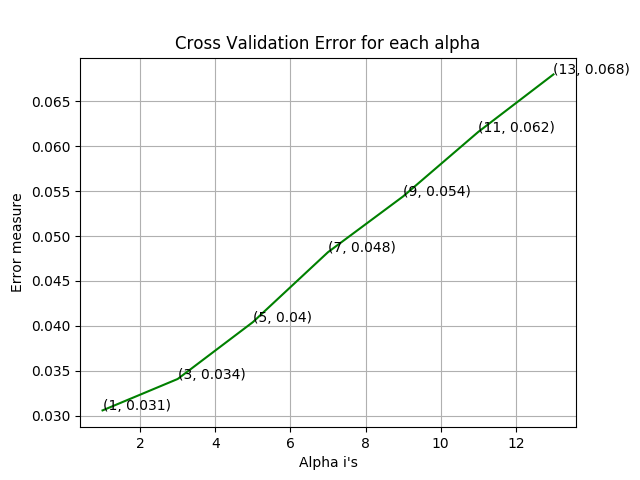

For values of best alpha =  1 The train log loss is: 0.010500463746556755
For values of best alpha =  1 The cross validation log loss is: 0.030577627471147225
For values of best alpha =  1 The test log loss is: 0.0363754311991678
Number of misclassified points  0.5059797608095675
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


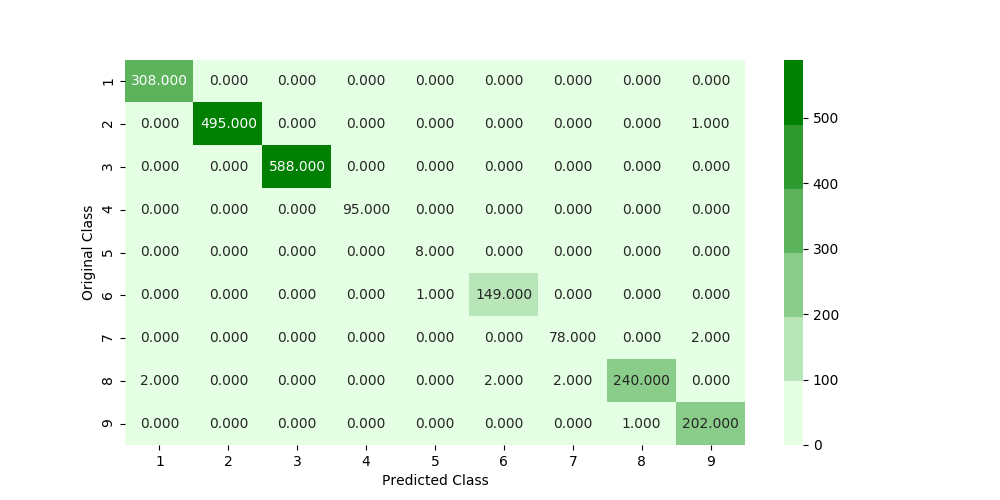

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


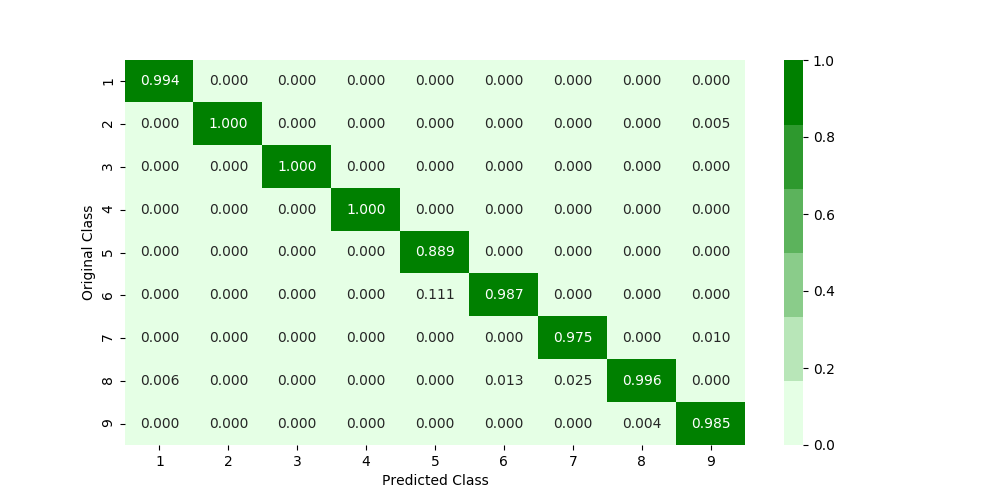

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


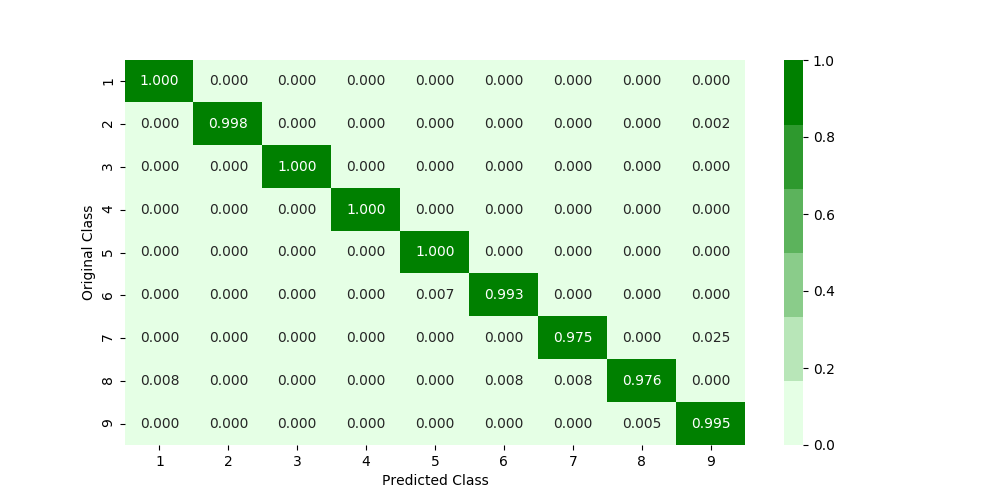

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [40]:
alpha = [x for x in range(1, 15, 2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

### Advance Features on Logistic Regression

log_loss for c =  1e-05 is 1.3304028477490337
log_loss for c =  0.0001 is 0.6214050660233997
log_loss for c =  0.001 is 0.3669625048491332
log_loss for c =  0.01 is 0.28349116866443896
log_loss for c =  0.1 is 0.1550026002660853
log_loss for c =  1 is 0.07146641052506307
log_loss for c =  10 is 0.04607788196251919
log_loss for c =  100 is 0.03882163572032281
log_loss for c =  1000 is 0.03978221345404225


<IPython.core.display.Javascript object>


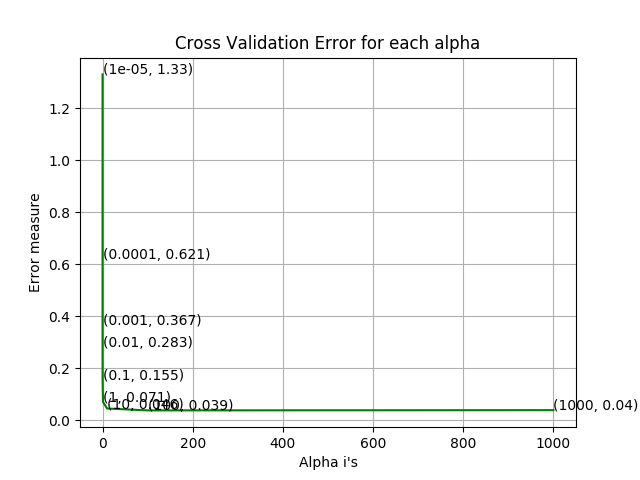

log loss for train data 0.03419445236082306
log loss for cv data 0.03882163572032281
log loss for test data 0.0494057571174993
Number of misclassified points  0.18399264029438822
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


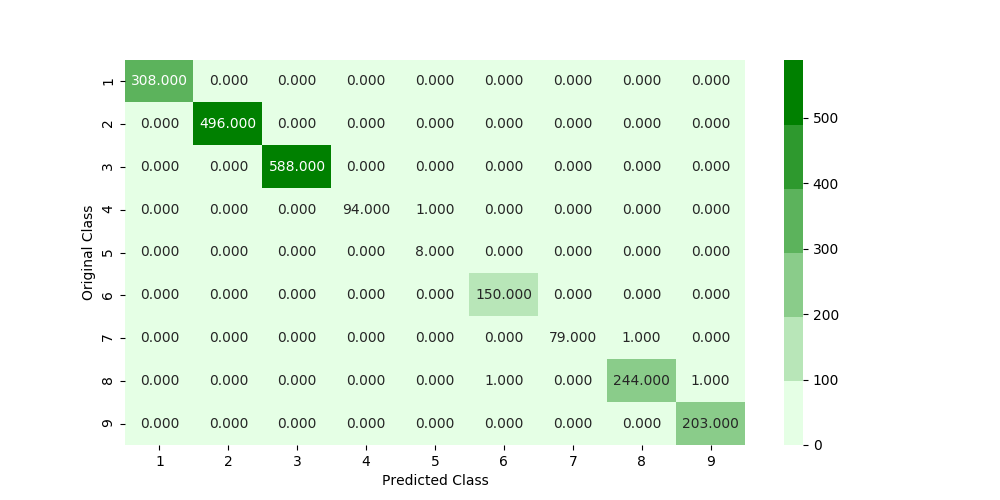

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


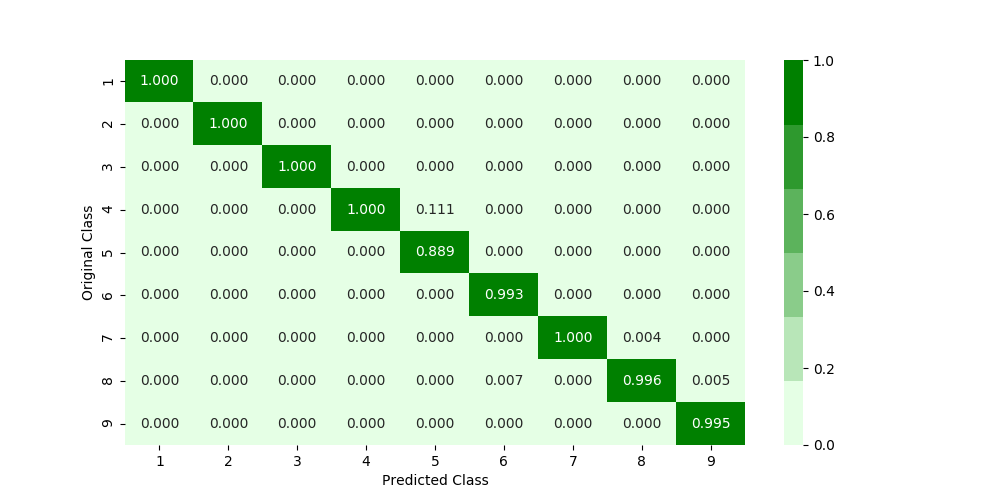

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


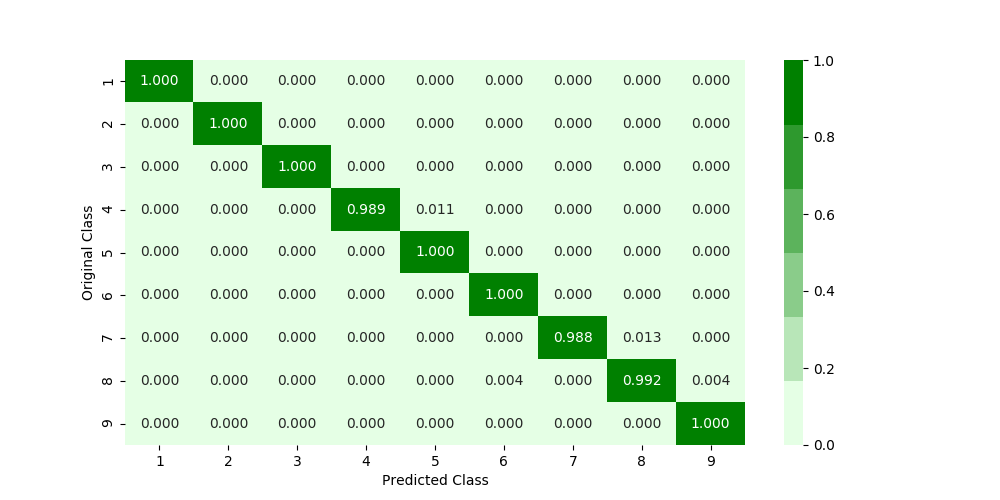

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [41]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
pred_y=sig_clf.predict(X_test)

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

### Random Forest Classifer on Advance Features

log_loss for c =  10 is 0.029263366195694095
log_loss for c =  50 is 0.024620356023329043
log_loss for c =  100 is 0.02457297402259238
log_loss for c =  500 is 0.024946638996541124
log_loss for c =  1000 is 0.025200817878291187
log_loss for c =  2000 is 0.024981579241973337
log_loss for c =  3000 is 0.025174258158549814


<IPython.core.display.Javascript object>


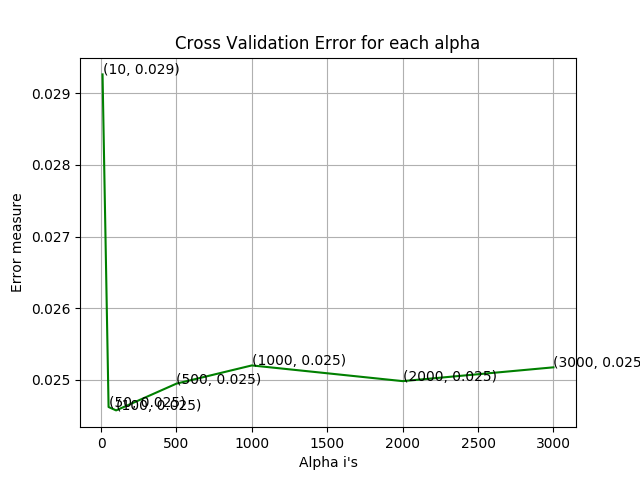

In [42]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  100 The train log loss is: 0.013100082053366893
For values of best alpha =  100 The cross validation log loss is: 0.02457297402259238
For values of best alpha =  100 The test log loss is: 0.026876026719149803
Number of misclassified points  0.5519779208831647
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


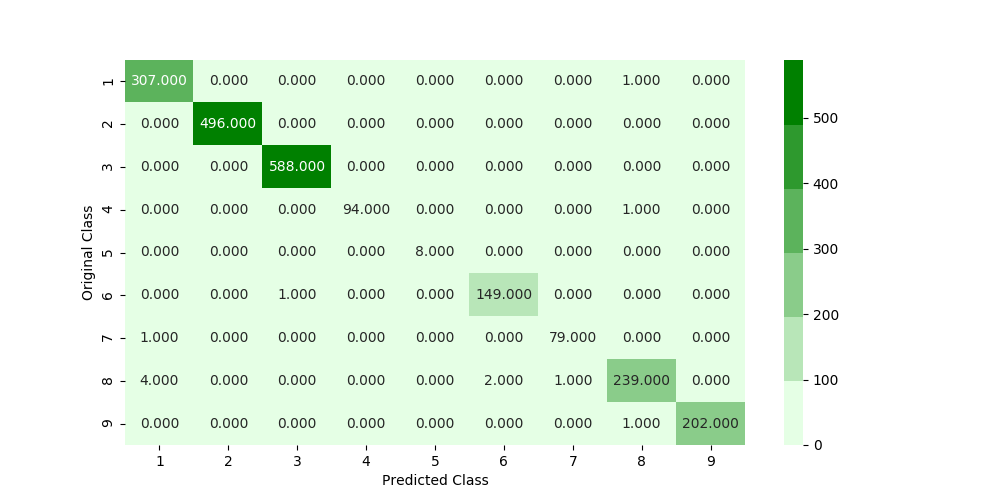

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


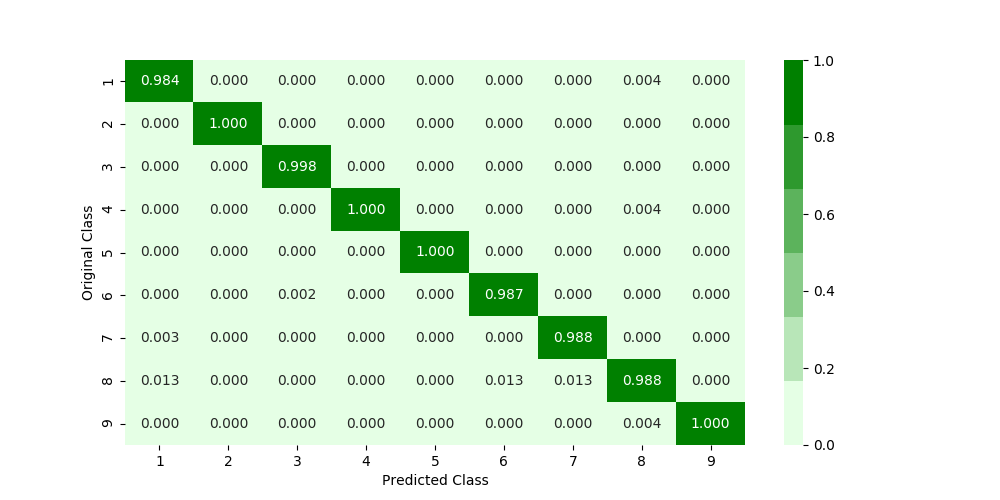

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


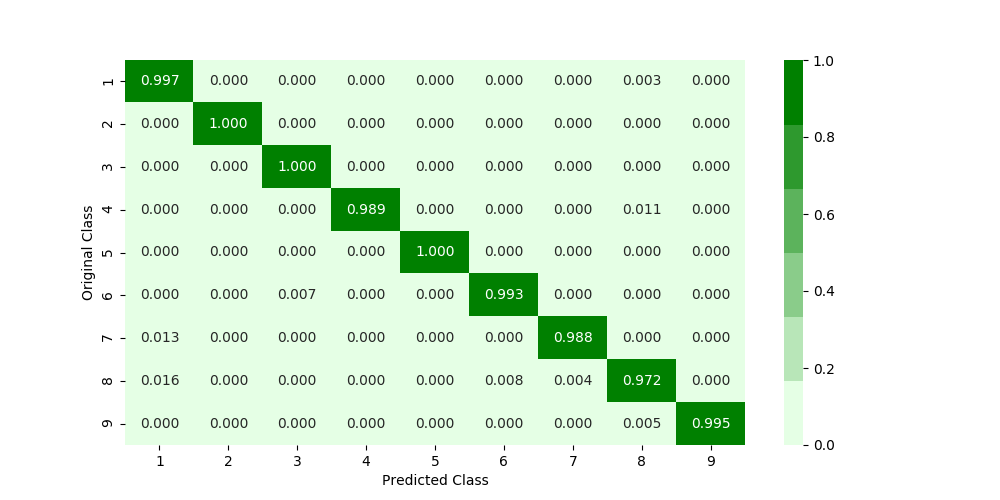

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [43]:
r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

#### Divide data into only train and test, to use random search CV on Random forest classifier and XG Boost classifier

In [54]:
data_y = result['Class_x']

X_train, X_test, y_train, y_test = train_test_split(result.drop(['ID','Class_x'], axis=1), data_y,stratify=data_y,test_size=0.20)

print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])

Number of data points in train data: 8694
Number of data points in test data: 2174


In [45]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=RandomForestClassifier()

prams={
    'min_samples_leaf':[1,2,4,6],
     'max_depth':[3,5,10,20,50],
    'n_estimators':[50,100,200,400,600,800,1000],
    'min_samples_split':[2,5,10]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,cv=5)
random_cfl1.fit(X_train,y_train)
print("="*70)
print("Best Hyperparameters")
best = random_cfl1.best_params_
print (random_cfl1.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  2.2min remaining:   29.2s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  2.4min remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.4min finished


Best Hyperparameters
{'min_samples_leaf': 2, 'max_depth': 50, 'n_estimators': 600, 'min_samples_split': 5}


train loss 0.01308356638869023
test loss 0.03303715069270835
Number of misclassified points  0.78196872125115
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


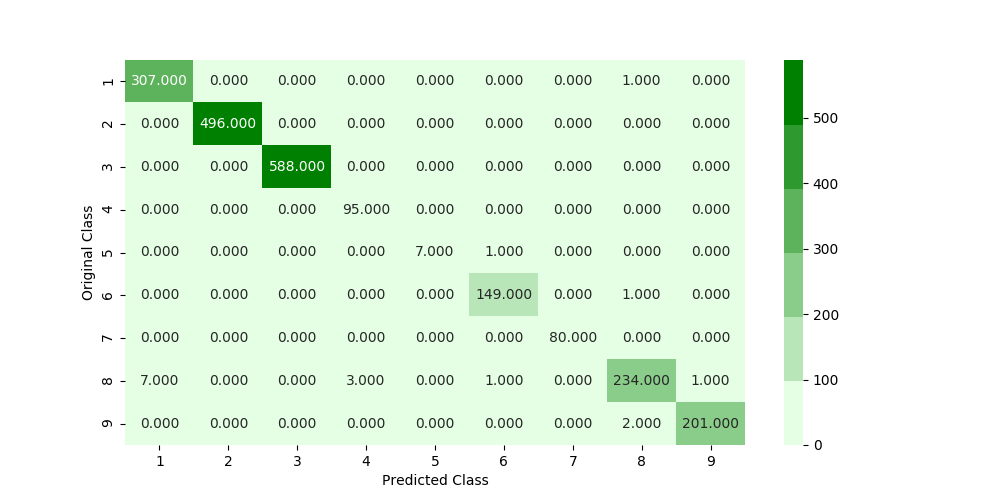

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


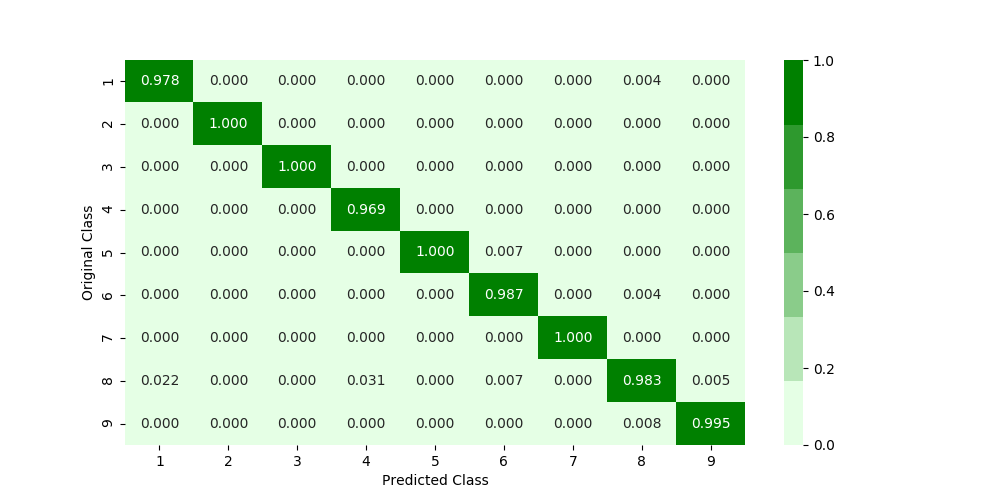

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


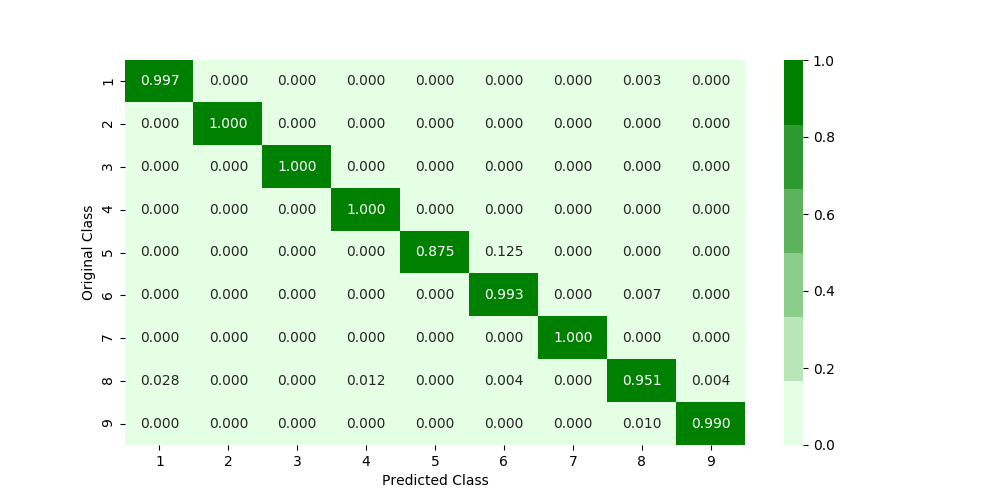

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [47]:
x_cfl=RandomForestClassifier(min_samples_split=5, max_depth=50, min_samples_leaf=2, n_estimators=600)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
#predict_y = c_cfl.predict_proba(X_cv)
#print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, c_cfl.predict(X_test))

In [11]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1)
random_cfl1.fit(X_train,y_train)
print("="*70)
print("Best Hyperparameters")
best = random_cfl1.best_params_
print (random_cfl1.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 18.7min remaining: 10.8min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 25.7min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 27.8min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 30.9min finished


Best Hyperparameters
{'max_depth': 10, 'colsample_bytree': 1, 'learning_rate': 0.1, 'subsample': 0.5, 'n_estimators': 500}


train loss 0.0038608315878971497
test loss 0.007450957000962961
Number of misclassified points  0.045998160073597055
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


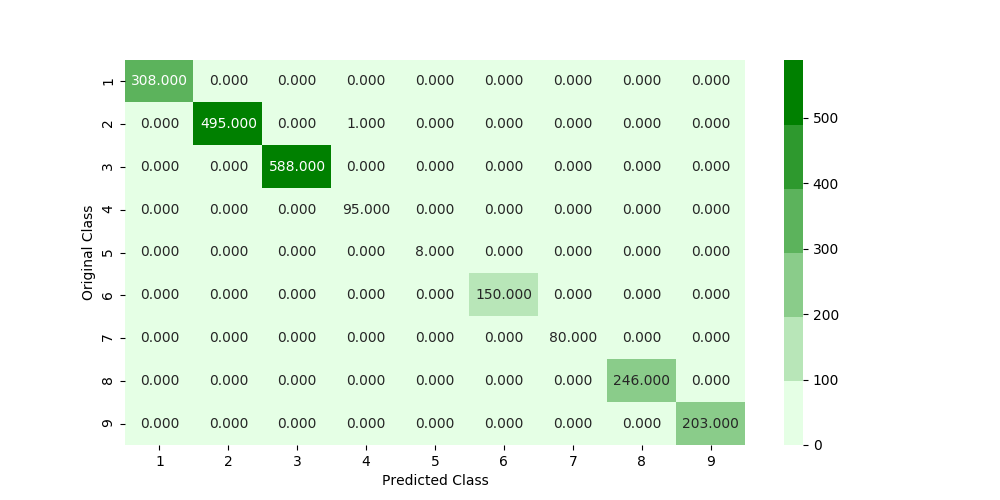

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


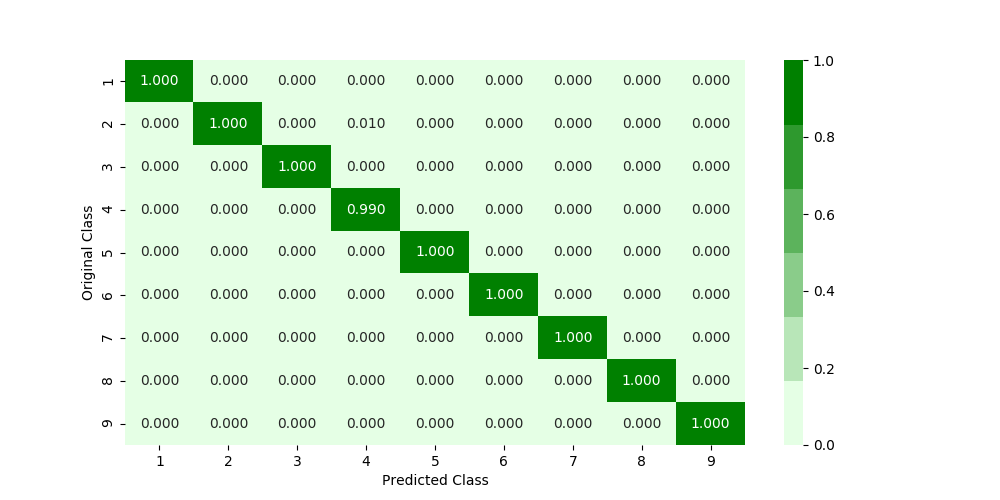

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


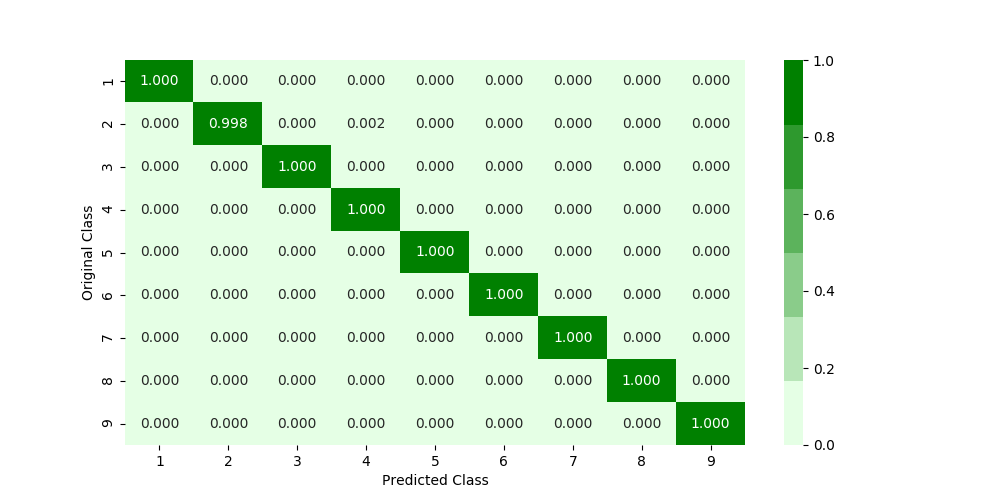

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [14]:
x_cfl=XGBClassifier(n_estimators=500, learning_rate=0.1, colsample_bytree=1, max_depth=10, subsample=0.5, n_jobs=-1)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
#predict_y = c_cfl.predict_proba(X_cv)
#print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, c_cfl.predict(X_test))

In [1]:
from prettytable import PrettyTable
x = PrettyTable()
x.title = 'Model Comparision'
x.field_names = ['Features','Model','Train-log loss', 'Missclassified pts.']
x.add_row(['Byte Files','Random','2.4850','88.50%'])
x.add_row(['Byte Files','K Nearest Neighbors','0.2154','5.519%'])
x.add_row(['Byte Files','Logistic Regression','0.557','13.431%'])
x.add_row(['Byte Files','Random Forest Classifier','0.081','1.79%'])
x.add_row(['Byte Files','XG Boost Classifier','0.077','1.47%'])
x.add_row(['Byte Files','XG Boost + H.Tuning','0.067','1.37%'])
x.add_row(['Byte Files Bigram','Random Forest Classifier','0.061','0.98%'])
x.add_row(['ASM files','Logistic Regression','0.381','6.07%'])
x.add_row(['ASM files','Random forest Classifier','0.037','0.68%'])
x.add_row(['ASM files','XG Boost + H.Tuning','0.0321','0.64%'])
x.add_row(['ASM opcode Unigram','Random Forest Classifier','0.103','2.25%'])
x.add_row(['ASM opcode Unigram','XG Boost','0.116','2.34%'])
x.add_row(['ASM opcode Bigram','Random Forest Classifier','0.078','1.56%'])
x.add_row(['ASM opcode Trigram','Random Forest Classifier','0.0708','1.37%'])
x.add_row(['ASM opcode Quadgram','Random Forest Classifier','0.107','2.29%'])
x.add_row(['ASM Image Features','Random Forest Classifier','1.04','38.36%'])
x.add_row(['Advance Features','K Nearest Neighbors','0.0204','0.184%'])
x.add_row(['Advance Features','Logistic Regression','0.055','0.3679%'])
x.add_row(['Advance Features','Random Forest Classifier','0.0236','0.4139%'])
x.add_row(['Advance Features','Random Forest + H.Tuning','0.028','0.64%'])
x.add_row(['Advance Features','XG Boost + H.Tuning','0.0074','0.0459%'])
print(x)

+---------------------+--------------------------+----------------+---------------------+
|       Features      |          Model           | Train-log loss | Missclassified pts. |
+---------------------+--------------------------+----------------+---------------------+
|      Byte Files     |          Random          |     2.4850     |        88.50%       |
|      Byte Files     |   K Nearest Neighbors    |     0.2154     |        5.519%       |
|      Byte Files     |   Logistic Regression    |     0.557      |       13.431%       |
|      Byte Files     | Random Forest Classifier |     0.081      |        1.79%        |
|      Byte Files     |   XG Boost Classifier    |     0.077      |        1.47%        |
|      Byte Files     |   XG Boost + H.Tuning    |     0.067      |        1.37%        |
|  Byte Files Bigram  | Random Forest Classifier |     0.061      |        0.98%        |
|      ASM files      |   Logistic Regression    |     0.381      |        6.07%        |
|      ASM

Advance Features have all Byte unigram features, top 300 byte bigram features, all ASM features, ASM opcode unigram features, ASM opcode bigram top 200 features, ASM opcode trigram top 200 features, ASM opcode quadgram top 200 features and ASM top 200 image features.

By using Advance Features with XG Boost with hyperparameter tuning I got unexpected results.
I use Random Search CV to train my model, and take cross validation = 5. 
Got Train loss = 0.0038, Test loss = 0.0074 and missclassified points percentage = 0.0459
This shows that our model is giving almost accurate results.

I can also say that we are not overfitting because our train loss and test loss are almost equal.